# TCAD Project

By Kelly Chu

# GitHub Repository

https://github.com/jameshowison/tcad_capstone.git 

The link above is a repository contains all of project's files and each file's revision history. However, the data and final deliverable file is too large that can not be stored in the GitHub, but could be run by this Jupyter notebook under Create and Export the deliverable table.


# Introduction

This project, started by a faculty colleague in urban studies, has a data dump from Travis Central Appraisal District (TCAD) on Austin property valuations in 1990 that exported around 2004. Where TCAD is the governmental entity responsible for appraising and assessing the value of all real and personal property in Travis County. Overall, the total size of these files are under 600MB uncompressed. The colleague would like to analyze these databases for his research, so the goal for this project is to gather the information and present the deliverable that would help in the research in the form that the faculty colleague can access it in a format that preferably in an excel sheet for all data. This project is a prototypical combo of archives, databases/data engineering, and some knowledge on geographic information system work.

From the given annotated microfiche, it labeled all the tasks with an example of the following information: Parcel, lots size, use, sq ft , effect date built, deed date, land appraised value, improvement appraised value, owner name, mailing address, location, and Legal description. The final outcome to the faculty colleague will present a table in excel sheet that specifically extracts the data of these columns.

The screenshots of annotated microfiche by the client:

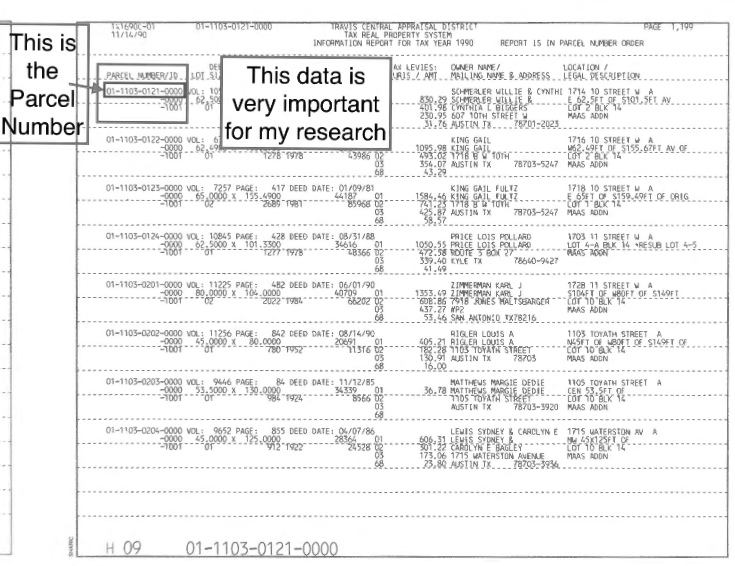







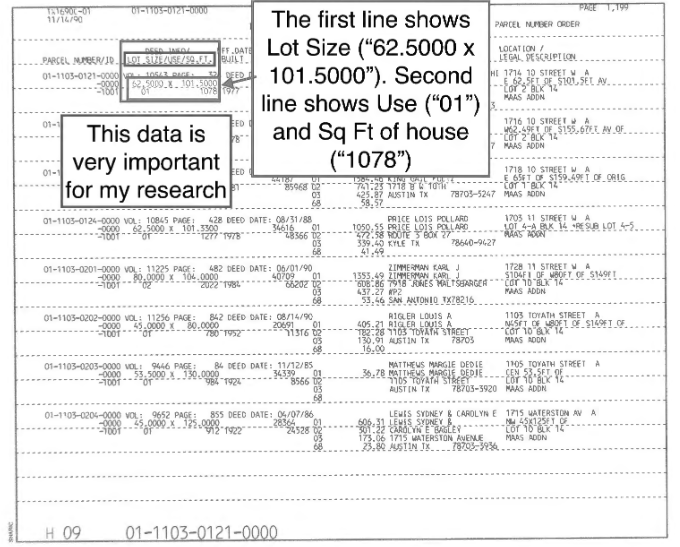

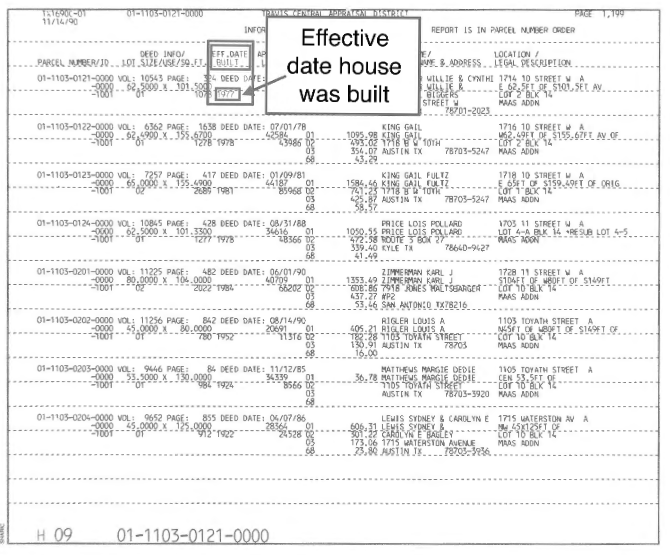


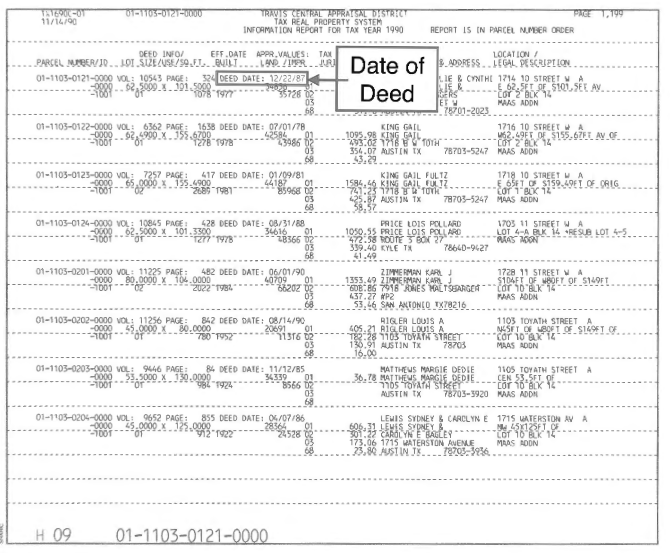

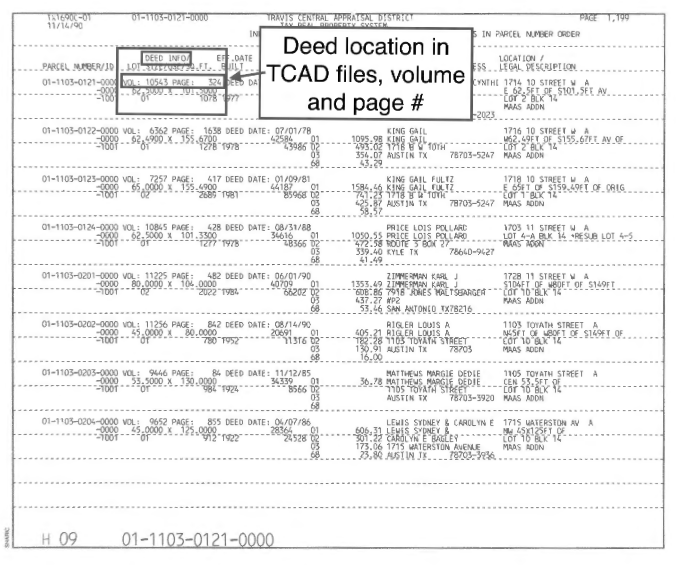

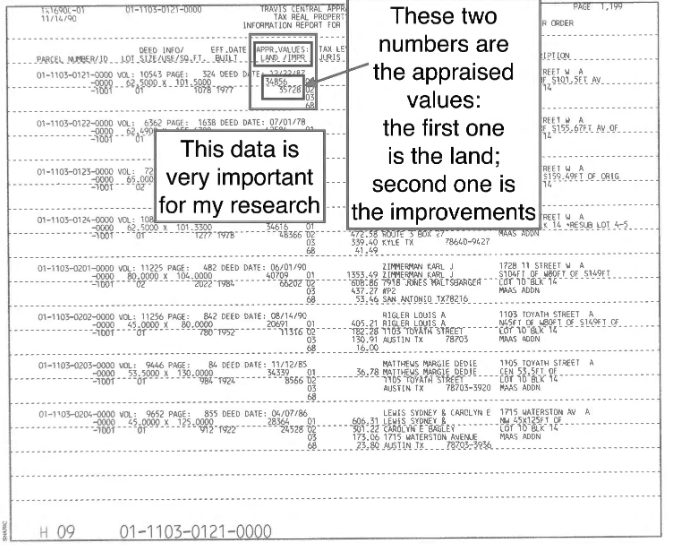

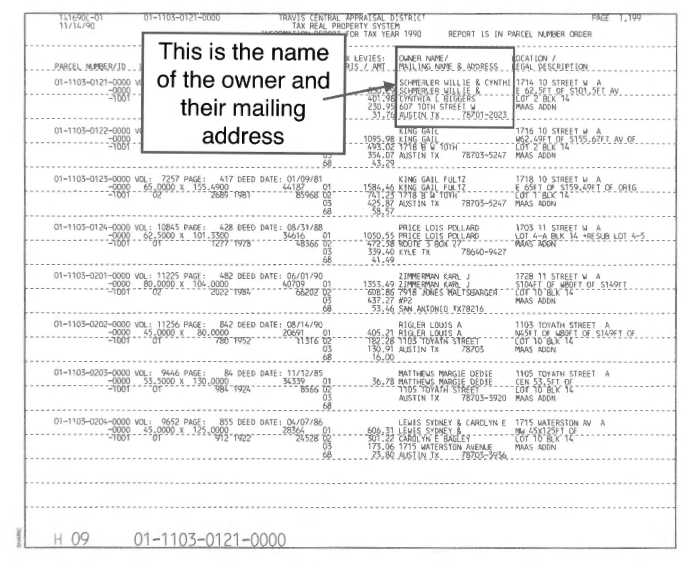

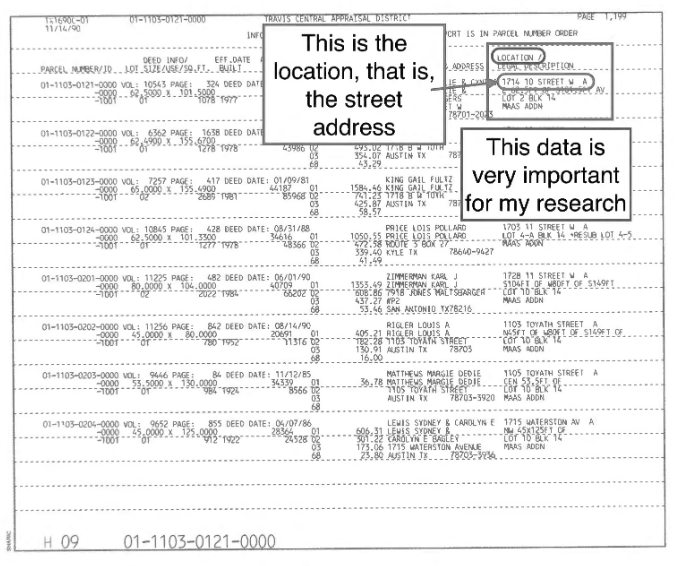

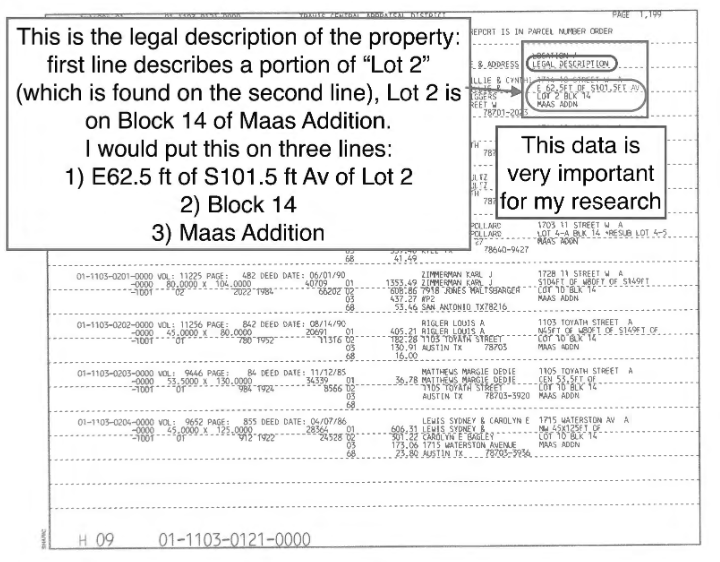

# TCAD file exploration

Within the folders, it contains 3 types of files:

-   IDX files: CREATE INDEX statements

-   TDF files: CREATE TABLE statements

-   Text files (TXT): data/ records

There are 2 general types of files, one is TCBC and the other is TXBC. From many searches, I assumed that TCBC is the abbreviation for Travis County Basic Code, and TXBC is the Travis County Extra-territory Basic Code. Where in these two general files there are some with suffixes following:

-   *CFOR (CFOR code)*

-   *GRANT_EXMP (grant exemption)*

-   *JURIS (jurisdiction)*: Each jurisdiction has its tax rate, which is used to calculate the property taxes owed on a particular property within that jurisdiction. The JURIS code is used by the appraisal district to identify the specific jurisdiction for each property within its jurisdictional area.

-   *JURIS_EXMP (jurisdiction exemption)*

-   *LEGAL (legal description)*: Typically used to identify and define the property for legal and taxation purposes, and it may include information such as the property's lot number, block number, subdivision name, survey name, and other identifying details. It's used to accurately identify and assess the value of a property for taxation purposes.

-   *SUSP (suspended)*: When a property's value or other information is in the dispute or has not been fully determined. The SUSP code is used by the appraisal district to indicate that the assessment of a particular property is currently suspended or on hold for some reason.

-   *SUSP_INIT (suspended initial*): The SUSP_INIT code is used by the appraisal district to indicate that the initial assessment of a particular property has been suspended.

However, by looking at the file description, noticing that the data only provided are `TCBC_SUM_1990`, `TCBC_SUM_1990_JURIS`, `TCBC_SUM_1990_LEGAL`, `TXBC_SUM_1990`, `TXBC_SUM_1990_JURIS`, `TXBC_SUM_1990_JURIS_EXMP`, `TXBC_SUM_1990_LEGAL`.

Other than the datasets provided by TCAD, I also created the data for the use code where the source is from page 59 of the Reappraisal Plan for Tax Years 2015-2016 by the Texas Comptroller of Public Account (Image 9). I have followed the formatting of .TXT and . TDF files the same way that was given, it is named `TXBC_SUM_1990_USECODE`. So, it allows me to upload the file into a folder where all files were unzipped and load the data all together in both folders A and B.

# Method and Tools

To accomplish the tasks in this project, we have used Google Sheets to save our findings and list out the notes that can be shared within the teams. To unzip and read the files given, we used Python from JupyterHub under the EduPod server and imported the extension called DuckDB for running the SQL code in the Jupyter Notebook.

Before using the tools above we have tried using Snowflakes and DBTCloud, using these two platforms we have difficulties to load the data that were given into its system. This may caused by lack of understanding of using these two platforms. We also tried using the Google Colab as the coding platform, but to be more accessible on collaboration work we use Jupyter notebook instead and practice using Git and load all documents onto GitHub repositoy that allow us to view or call back any edit history. 


# Shorten files for browsing

To shorten the files for browsing we can run a short shell script. This opens the zip that was received, and truncates each file at 100 lines long.

```{bash, eval=F}
# rm -rf shortened_appraisal_files
unzip original_data/Appraisal_Roll_History_1990.zip -d shortened_appraisal_files
find shortened_appraisal_files -name "*.TXT" -exec sed -i.full 100q {} \;
find shortened_appraisal_files -name "*.TXT.full" -exec rm {} \;
zip -r shortened_appraisal_files.zip shortened_appraisal_files
```

We can now attempt to load a shortened file using pandas

In [1]:
# !pip install openpyxl
import pandas as pd

# df = pd.read_csv("shortened_appraisal_files/Appraisal_Roll_History_1990_A/TCBC_SUM_1990_JURIS.TXT", sep = "|")
# df.head()

Manually add the UseCode files into the zipped folder.

In [2]:
# extract zip folder into a new folder
import zipfile
import os

# zip_file_path = "shortened_appraisal_files.zip"
zip_file_path = "Appraisal_Roll_History_1990.zip"
extract_folder_path = "data"

# Create the extract folder if it doesn't exist
if not os.path.exists(extract_folder_path):
    os.makedirs(extract_folder_path)

# Open the zip file and extract its contents to the extract folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

Challenge now is to use the *.TDF files to create tables.  I can think of two approaches.

1. The TDF files are SQL, so if those are fed to duckdb they should be able to create tables into which the TXT pipe-separated CSV files can be read.  There may be issues with the datatypes not matching (which would require mapping the current datatype definitions to duckdb datatypes by changing the words used to give the datatype to the columns).

2. Take the column names out of the TDF files and add them as the column names while reading the relevant CSV files into duckdb.  This would use duckdb's auto understanding of the column datatypes (so it would run, but it might guess wrongly and truncate or change data).


## Creating tables using the TDF files

We have TDF files scattered through the \_A and \_B folders.  I have created a schema (a namespace) for the files from \_A called "folder_A" and "folder_B". So there are tables named the same thing in each of the schemas.  You can reference the tables as folder_A.TCBC_SUM_1990_JURIS and folder_B.TCBC_SUM_1990_JURIS 

We can use python to read each TDF file separately, create the table and then try to load the matching TXT file.  A little guidance on how to process a directory structure of files using Path and glob here:
http://howisonlab.github.io/datawrangling/faq.html#get-data-from-filenames

In [3]:
# !pip install duckdb

import csv
from pathlib import Path
import duckdb

con = duckdb.connect('duckdb-file.db') #  string to persist to disk
cursor = con.cursor()

# file_directory = 'shortened_appraisal_files/'
file_directory = 'data/'
# limit_to_file = 'TCBC_SUM_1990_JURIS'
limit_to_file = '*' # all files

# create schemas
cursor.execute("CREATE SCHEMA IF NOT EXISTS folder_A_TCBC;")
cursor.execute("CREATE SCHEMA IF NOT EXISTS folder_A_TXBC;")
cursor.execute("CREATE SCHEMA IF NOT EXISTS folder_B_TCBC;")
cursor.execute("CREATE SCHEMA IF NOT EXISTS folder_B_TXBC;")
# delete schemas that created previously
# cursor.execute("DROP SCHEMA IF EXISTS folder_A CASCADE")
# cursor.execute("DROP SCHEMA IF EXISTS folder_B CASCADE")

for filename in Path(file_directory).rglob(limit_to_file + '.TDF'):
    print(filename.parts)
    if "_A" in filename.parts[1] and "TCBC_" in filename.parts[2]:
        schema = "folder_A_TCBC"
    elif "_A" in filename.parts[1] and "TXBC_" in filename.parts[2]:
        schema = "folder_A_TXBC"
    elif "_B" in filename.parts[1] and "TCBC_" in filename.parts[2]:
        schema = "folder_B_TCBC"
    elif "_B" in filename.parts[1] and "TXBC_" in filename.parts[2]:
        schema = "folder_B_TXBC"
    else:
        exit("can't set schema")
    
    table_name = schema + "." + Path(filename).stem # e.g., A_TCBC_SUM_1990_JURIS

    # read .TDF file into string
    create_table_sql = Path(filename).read_text()
    # Need to alter table name to read in both _A and _B files
    create_table_sql = create_table_sql.replace(Path(filename).stem, table_name)
    
    # Here we have the table creation code in a string, so we can
    # swap datatypes out.
    # tried SMALLDATETIME --> DATETIME but was still giving errors
    # will need to fix this later.
    create_table_sql = create_table_sql.replace("SMALLDATETIME", "TEXT")
    create_table_sql = create_table_sql.replace("CREATE TABLE", "CREATE TABLE IF NOT EXISTS")    
    create_table_sql = f"DROP TABLE IF EXISTS {table_name}; "+ create_table_sql
    

    # execute that SQL with duckdb, this should create the table
    # already created table so no need to run
    #print(create_table_sql)
    #exit(1)
    cursor.execute(create_table_sql) 

    # copy CSV into duckdb. CSV is the matching .TXT
    path_to_csvpipefile = Path(filename).with_suffix(".TXT")
    # duckdb copy documentation: https://duckdb.org/docs/sql/statements/copy.html
    query = f"COPY {table_name} FROM '{path_to_csvpipefile}' ( DELIMITER '|')"
    # print(query)
    cursor.execute(query)

('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_CFOR.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_GRANT_EXMP.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_JURIS.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_JURIS_EXMP.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_LEGAL.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_SUSP.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TCBC_SUM_1990_SUSP_INIT.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990_CFOR.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990_GRANT_EXMP.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990_JURIS.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990_JURIS_EXMP.TDF')
('data', 'Appraisal_Roll_History_1990_A', 'TXBC_SUM_1990_LEGAL.TDF')
('data', 'Appraisal_Roll_

# Create the tables for dbdocs

In [4]:
# set up sql for dbdocs
for filename in Path(file_directory).rglob(limit_to_file + '.TDF'):

    # read .TDF file into string
    dbdocs_create_table = Path(filename).read_text()

    # Remove commas before closing parentheses using regular expressions
    dbdocs_create_table = dbdocs_create_table.replace("),", ")")

    # Replacements for dbdocs
    dbdocs_create_table = dbdocs_create_table.replace("CREATE TABLE", "TABLE")
    dbdocs_create_table = dbdocs_create_table.replace("SMALLDATETIME", "TEXT")
    dbdocs_create_table = dbdocs_create_table.replace("TEXT,", "TEXT")
    dbdocs_create_table = dbdocs_create_table.replace(" (", "{ ")
    dbdocs_create_table = dbdocs_create_table.replace(");", " }")
    
    # Print the updated SQL table code
    print(dbdocs_create_table)


TABLE TCBC_SUM_1990{ 
AcctNum VARCHAR(10)
SufxId VARCHAR(4)
TaxYear VARCHAR(4)
RunDate TEXT
KeyCode VARCHAR(2)
LoanCo NUMERIC(4,0)
LoanNum VARCHAR(15)
ExmpCode VARCHAR(2)
LocStreet VARCHAR(20)
LocHouse VARCHAR(6)
LocFrac VARCHAR(3)
LocAlpha VARCHAR(1)
LocUnit VARCHAR(5)
LocZip VARCHAR(5)
FmtLoc VARCHAR(30)
RendFlag VARCHAR(1)
TotSqft NUMERIC(9,0)
OthAcctDist VARCHAR(1)
OthAcctNum VARCHAR(17)
AddrSuppressCode VARCHAR(1)
Area VARCHAR(2)
PropType VARCHAR(1)
NOAVPrintCode VARCHAR(1)
AVChangeFlag VARCHAR(1)
SICCode VARCHAR(8)
CPPRRcvdCode VARCHAR(1)
ApprSelect VARCHAR(1)
MarinaAirfield VARCHAR(3)
LinkParcel VARCHAR(10)
PTDCode VARCHAR(2)
PTDComplexFlag VARCHAR(1)
ApprInit VARCHAR(3)
ApprInit2 VARCHAR(3)
OwnerName VARCHAR(30)
FirmName VARCHAR(58)
ValSetFlag VARCHAR(1)
ValSetInit VARCHAR(3)
AgentTCAD VARCHAR(4)
AgentARB VARCHAR(4)
AgentCOLL VARCHAR(4)
Zip5 VARCHAR(5)
Zip4 VARCHAR(4)
Zip2 VARCHAR(2)
MailCnt NUMERIC(1,0)
MailAddr1 VARCHAR(30)
MailAddr2 VARCHAR(30)
MailAddr3 VARCHAR(30)
MailAddr

By using dbdiagram we are able to generate an Entitiy Relation Diagram (ER Diagram). When using this platform, its require to have space in front of the content using the oucome created above. In this project, I've created an ER diagram focusing on the TXBC files is having data. 

https://dbdiagram.io/d/64440b406b3194705105fb93

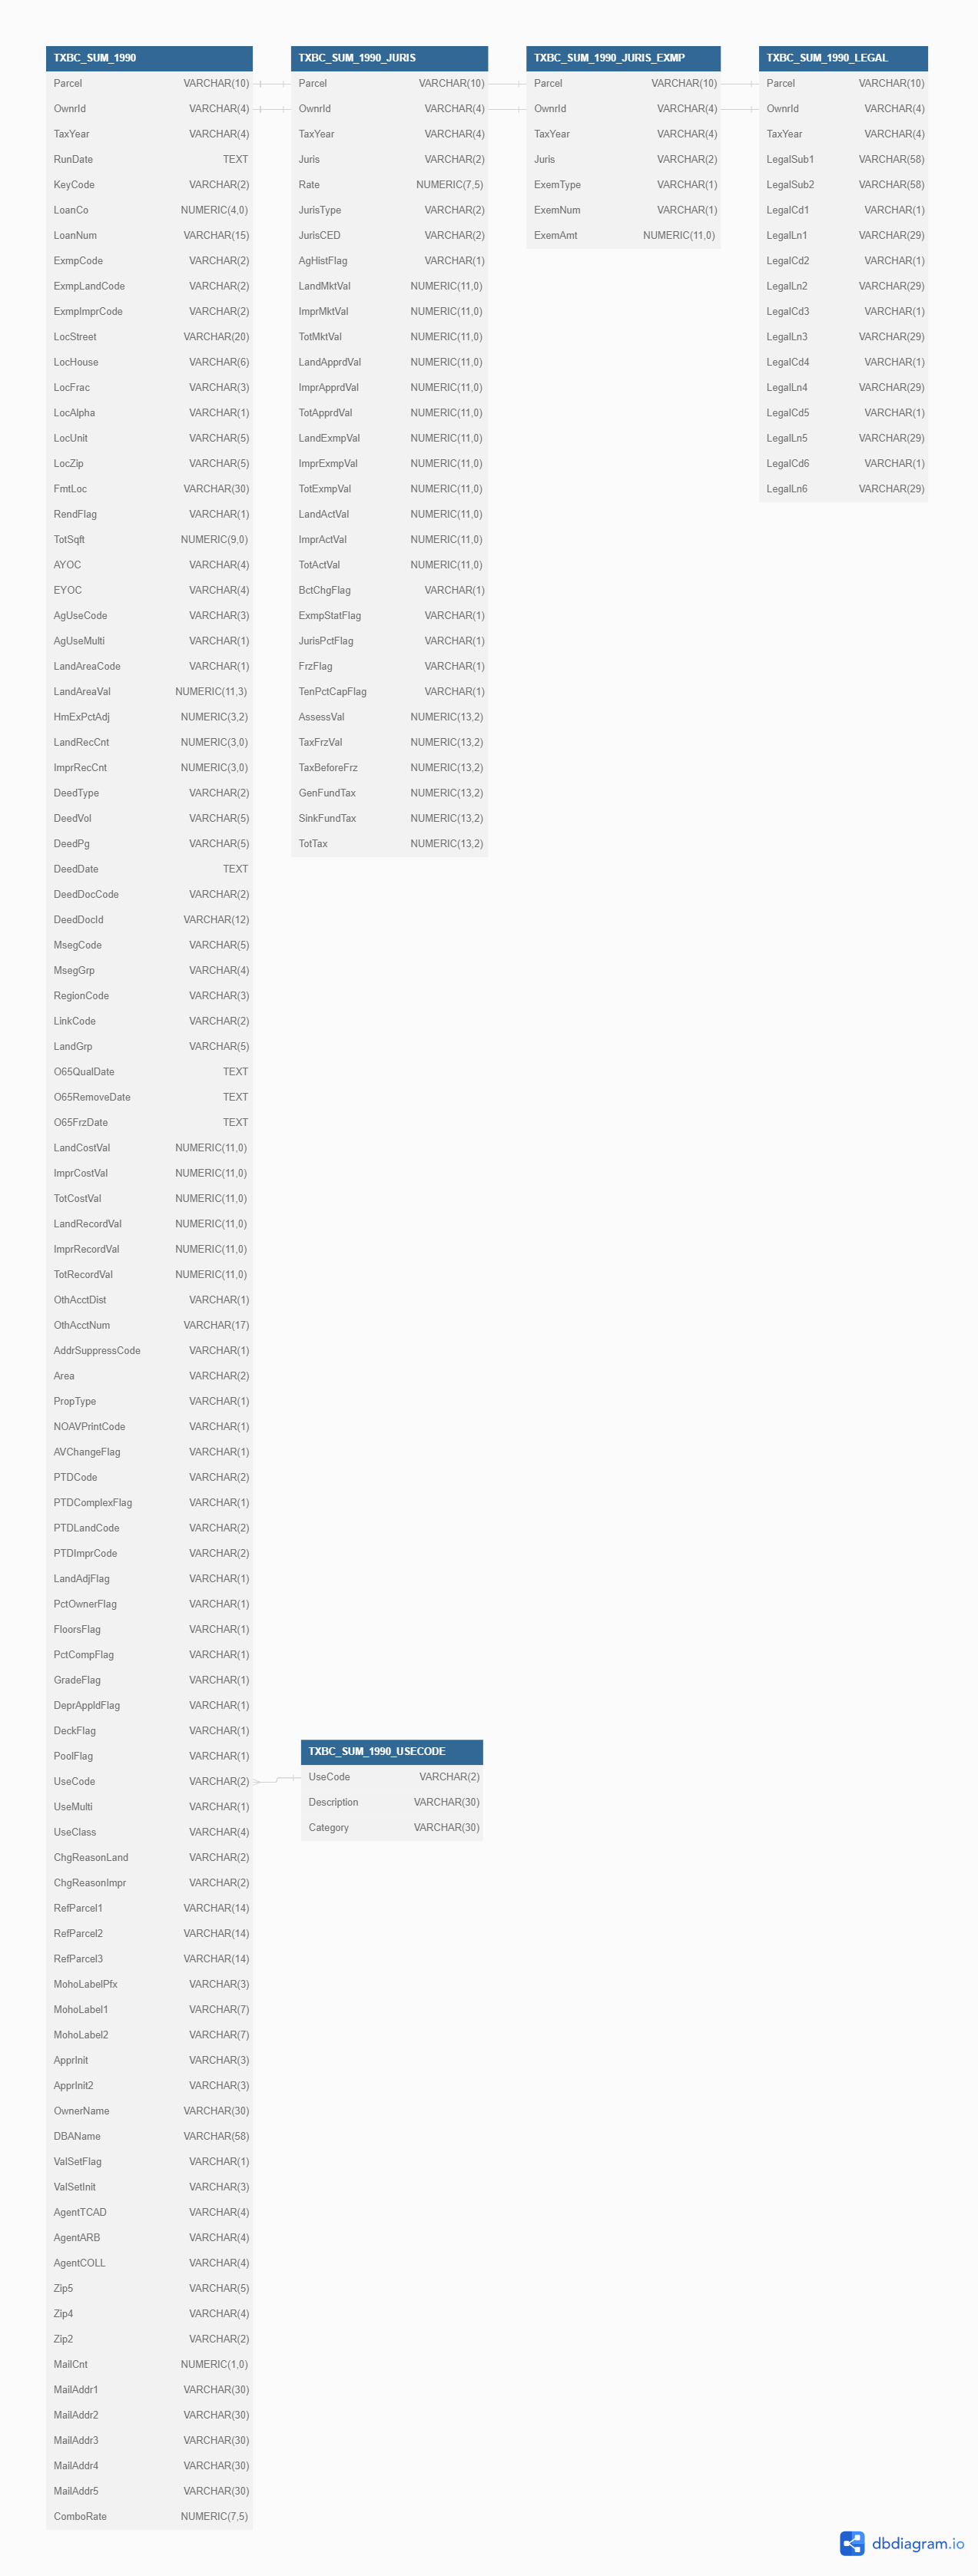

# Data / Files exploration

Interestingly, these two folders (Appraisal_Roll_History_1990_A and Appraisal_Roll_History_1990_B) contain the exact same files and in all files it has exactly the same information. This can be shown by running a python code that compare the folder:

In [5]:
import os

folder_A = 'data/Appraisal_Roll_History_1990_A'
folder_B = 'data/Appraisal_Roll_History_1990_B'

for filename in os.listdir(folder_A):
    file_A = os.path.join(folder_A, filename)
    file_B = os.path.join(folder_B, filename)

    with open(file_A, "r") as a, open(file_B, "r") as b:
        data_A = a.read()
        data_B = b.read()

    if data_A == data_B:
        print(f"{filename}: Files are identical.")
    else:
        print(f"{filename}: Files are different.")


RPT_TC2333_1990_20040701_162440.TXT: Files are identical.
RPT_TX1333_1990_20040701_162440.TXT: Files are identical.
TCBC_SUM_1990.IDX: Files are identical.
TCBC_SUM_1990.TDF: Files are identical.
TCBC_SUM_1990.TXT: Files are identical.
TCBC_SUM_1990_CFOR.IDX: Files are identical.
TCBC_SUM_1990_CFOR.TDF: Files are identical.
TCBC_SUM_1990_CFOR.TXT: Files are identical.
TCBC_SUM_1990_GRANT_EXMP.IDX: Files are identical.
TCBC_SUM_1990_GRANT_EXMP.TDF: Files are identical.
TCBC_SUM_1990_GRANT_EXMP.TXT: Files are identical.
TCBC_SUM_1990_JURIS.IDX: Files are identical.
TCBC_SUM_1990_JURIS.TDF: Files are identical.
TCBC_SUM_1990_JURIS.TXT: Files are identical.
TCBC_SUM_1990_JURIS_EXMP.IDX: Files are identical.
TCBC_SUM_1990_JURIS_EXMP.TDF: Files are identical.
TCBC_SUM_1990_JURIS_EXMP.TXT: Files are identical.
TCBC_SUM_1990_LEGAL.IDX: Files are identical.
TCBC_SUM_1990_LEGAL.TDF: Files are identical.
TCBC_SUM_1990_LEGAL.TXT: Files are identical.
TCBC_SUM_1990_SUSP.IDX: Files are identical.
TC

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 65: character maps to <undefined>

# SQL for analysis

In [6]:
# !pip install jupysql
# !pip install duckdb-engine

# setup from https://duckdb.org/docs/guides/python/jupyter.html
import duckdb
import pandas as pd
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [7]:
pd.options.display.max_columns = None

In [8]:
%sql duckdb:///duckdb-file.db

In [9]:
%%sql
SHOW TABLES -- no schema name

name
0              TCBC_SUM_1990
1              TCBC_SUM_1990
2         TCBC_SUM_1990_CFOR
3         TCBC_SUM_1990_CFOR
4   TCBC_SUM_1990_GRANT_EXMP
5   TCBC_SUM_1990_GRANT_EXMP
6        TCBC_SUM_1990_JURIS
7        TCBC_SUM_1990_JURIS
8   TCBC_SUM_1990_JURIS_EXMP
9   TCBC_SUM_1990_JURIS_EXMP
10       TCBC_SUM_1990_LEGAL
11       TCBC_SUM_1990_LEGAL
12        TCBC_SUM_1990_SUSP
13        TCBC_SUM_1990_SUSP
14   TCBC_SUM_1990_SUSP_INIT
15   TCBC_SUM_1990_SUSP_INIT
16             TXBC_SUM_1990
17             TXBC_SUM_1990
18        TXBC_SUM_1990_CFOR
19        TXBC_SUM_1990_CFOR
20  TXBC_SUM_1990_GRANT_EXMP
21  TXBC_SUM_1990_GRANT_EXMP
22       TXBC_SUM_1990_JURIS
23       TXBC_SUM_1990_JURIS
24  TXBC_SUM_1990_JURIS_EXMP
25  TXBC_SUM_1990_JURIS_EXMP
26       TXBC_SUM_1990_LEGAL
27       TXBC_SUM_1990_LEGAL
28        TXBC_SUM_1990_SUSP
29        TXBC_SUM_1990_SUSP
30   TXBC_SUM_1990_SUSP_INIT
31   TXBC_SUM_1990_SUSP_INIT
32     TXBC_SUM_1990_USECODE
33     TXBC_SUM_1990_USECODE

Hey, duckdb implements all the same information schema names as postgres, so one can use the same queries to find the tables with their schaema names.

In [10]:
%%sql
SELECT schemaname AS schema_name, tablename AS table_name
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog'
AND schemaname != 'information_schema'
ORDER BY schemaname, tablename ASC;

schema_name                table_name
0   folder_A_TCBC             TCBC_SUM_1990
1   folder_A_TCBC        TCBC_SUM_1990_CFOR
2   folder_A_TCBC  TCBC_SUM_1990_GRANT_EXMP
3   folder_A_TCBC       TCBC_SUM_1990_JURIS
4   folder_A_TCBC  TCBC_SUM_1990_JURIS_EXMP
5   folder_A_TCBC       TCBC_SUM_1990_LEGAL
6   folder_A_TCBC        TCBC_SUM_1990_SUSP
7   folder_A_TCBC   TCBC_SUM_1990_SUSP_INIT
8   folder_A_TXBC             TXBC_SUM_1990
9   folder_A_TXBC        TXBC_SUM_1990_CFOR
10  folder_A_TXBC  TXBC_SUM_1990_GRANT_EXMP
11  folder_A_TXBC       TXBC_SUM_1990_JURIS
12  folder_A_TXBC  TXBC_SUM_1990_JURIS_EXMP
13  folder_A_TXBC       TXBC_SUM_1990_LEGAL
14  folder_A_TXBC        TXBC_SUM_1990_SUSP
15  folder_A_TXBC   TXBC_SUM_1990_SUSP_INIT
16  folder_A_TXBC     TXBC_SUM_1990_USECODE
17  folder_B_TCBC             TCBC_SUM_1990
18  folder_B_TCBC        TCBC_SUM_1990_CFOR
19  folder_B_TCBC  TCBC_SUM_1990_GRANT_EXMP
20  folder_B_TCBC       TCBC_SUM_1990_JURIS
21  folder_B_TCBC  TCBC_SUM_1990_JURIS_EXMP
22  folder_B_TCBC       TCBC_SUM_1990_LEGAL
23  folder_B_TCBC        TCBC_SUM_1990_SUSP
24  folder_B_TCBC   TCBC_SUM_1990_SUSP_INIT
25  folder_B_TXBC             TXBC_SUM_1990
26  folder_B_TXBC        TXBC_SUM_1990_CFOR
27  folder_B_TXBC  TXBC_SUM_1990_GRANT_EXMP
28  folder_B_TXBC       TXBC_SUM_1990_JURIS
29  folder_B_TXBC  TXBC_SUM_1990_JURIS_EXMP
30  folder_B_TXBC       TXBC_SUM_1990_LEGAL
31  folder_B_TXBC        TXBC_SUM_1990_SUSP
32  folder_B_TXBC   TXBC_SUM_1990_SUSP_INIT
33  folder_B_TXBC     TXBC_SUM_1990_USECODE

The table without a suffix (TCBC_SUM_1990) has only 28,086 rows.  Perhaps these are accounts for individual tax payers, but individual tax payers can have multiple account number.

In [11]:
%%sql
SELECT * FROM folder_A_TCBC.TCBC_SUM_1990;

AcctNum SufxId TaxYear     RunDate KeyCode LoanCo LoanNum ExmpCode  \
0      0000000003   0000    1990  1992-07-06    None      0    None     None   
1      0000000007   0000    1990  1992-07-06    None      0    None     None   
2      0000000014   0000    1990  1992-07-06    None      0    None     None   
3      0000000015   0000    1990  1992-07-06    None      0    None     None   
4      0000000018   0000    1990  1992-07-06    None      0    None     None   
...           ...    ...     ...         ...     ...    ...     ...      ...   
28081  0000060425   0000    1990  1992-07-06    None      0    None     None   
28082  0000060456   0000    1990  1992-07-06    None      0    None     None   
28083  0000060832   0000    1990  1992-07-06    None      0    None     None   
28084  0000060999   0000    1990  1992-07-06    None      0    None     None   
28085  0000061017   0000    1990  1992-07-06    None      0    None     None   

                 LocStreet LocHouse LocFrac LocAlpha LocUnit LocZip  \
0                MO-PAC CI   001004    None     None   00101  78746   
1                   5 ST E   002811    None     None    None  MULTI   
2             KENTSHIRE CI   000603    None     None    None  78704   
3           BEN WHITE BV E   004818    None     None   00202  MULTI   
4                BURNET RD   004402    None     None    None  MULTI   
...                    ...      ...     ...      ...     ...    ...   
28081         RED RIVER ST   000912    None     None    None  MULTI   
28082  WILLIAM CANNON DR W   000414    None     None   00008   None   
28083          AMERICAN DR   003404    None     None    None  78641   
28084           YAGER LN W   000615    None     None    None  78753   
28085           AIRPORT BV   004005    None     None    None  MULTI   

                          FmtLoc RendFlag TotSqft OthAcctDist OthAcctNum  \
0             1004 MO-PAC CI 101     None       0        None       None   
1                   2811  5 ST E     None       0        None       None   
2               603 KENTSHIRE CI     None       0        None       None   
3        4818 BEN WHITE BV E 202     None       0        None       None   
4                 4402 BURNET RD     None       0        None       None   
...                          ...      ...     ...         ...        ...   
28081           912 RED RIVER ST     None       0        None       None   
28082  414 WILLIAM CANNON DR W 8     None       0        None       None   
28083           3404 AMERICAN DR     None       0        None       None   
28084             615 YAGER LN W     None       0        None       None   
28085            4005 AIRPORT BV     None       0        None       None   

      AddrSuppressCode Area PropType NOAVPrintCode AVChangeFlag SICCode  \
0                 None    P        C          None         None    None   
1                 None    P        C          None         None    None   
2                 None    P        C          None         None    None   
3                 None    P        C          None         None    None   
4                 None    P        C          None         None    None   
...                ...  ...      ...           ...          ...     ...   
28081             None    P        C          None         None    None   
28082             None    P        C          None         None    5992   
28083             None    P        B          None         None    None   
28084             None    P        C          None         None    None   
28085             None    P        C          None         None    None   

      CPPRRcvdCode ApprSelect MarinaAirfield LinkParcel PTDCode  \
0                N       None           None       None      L1   
1                N       None           None       None      L1   
2                Y       None           None       None      L1   
3                Y       None           None       None      L1   
4                N       None           None   

Skip down to middle data of to look into detail information of the TCBC summary file.

In [12]:
%%sql
SELECT * FROM folder_A_TCBC.TCBC_SUM_1990
LIMIT 100
OFFSET 20000;

AcctNum SufxId TaxYear     RunDate KeyCode LoanCo LoanNum ExmpCode  \
0   0000046663   0000    1990  1992-07-06    None      0    None     None   
1   0000046666   0000    1990  1992-07-06    None      0    None     None   
2   0000046667   0000    1990  1992-07-06    None      0    None     None   
3   0000046668   0000    1990  1992-07-06    None      0    None     None   
4   0000046680   0000    1990  1992-07-06    None      0    None     None   
..         ...    ...     ...         ...     ...    ...     ...      ...   
95  0000046847   0002    1990  1992-07-06    None      0    None     None   
96  0000046847   0003    1990  1992-07-06    None      0    None     None   
97  0000046847   0004    1990  1992-07-06    None      0    None     None   
98  0000046847   0006    1990  1992-07-06    None      0    None     None   
99  0000046847   0007    1990  1992-07-06    None      0    None     None   

             LocStreet LocHouse LocFrac LocAlpha LocUnit LocZip  \
0       SHOAL CREEK BV   008900    None     None   00103  MULTI   
1         LA POSADA DR   001016    None     None   00174  78752   
2           TOMANET TR   012412    None     None    None   None   
3        ANDERSON LN W   001810    None     None    None  MULTI   
4           HIDALGO ST   003411    None     None    None  78702   
..                 ...      ...     ...      ...     ...    ...   
95  CAPITAL OF TX HY N   009020    None     None   00335  MULTI   
96          THERMAL DR   013804    None        C    None   None   
97        BEE CAVES RD   004015    None        A    None  MULTI   
98       CONGRESS AV S   007110    None        B    None  MULTI   
99      SAN ANTONIO ST   001205    None     None    None   None   

                         FmtLoc RendFlag TotSqft OthAcctDist OthAcctNum  \
0       8900 SHOAL CREEK BV 103     None       0        None       None   
1         1016 LA POSADA DR 174     None       0        None       None   
2              12412 TOMANET TR        Y       0        None       None   
3            1810 ANDERSON LN W     None       0        None       None   
4               3411 HIDALGO ST        Y       0        None       None   
..                          ...      ...     ...         ...        ...   
95  9020 CAPITAL OF TX HY N 335     None       0        None       None   
96            13804C THERMAL DR     None       0        None       None   
97           4015A BEE CAVES RD     None       0        None       None   
98          7110B CONGRESS AV S     None       0        None       None   
99          1205 SAN ANTONIO ST     None       0        None       None   

   AddrSuppressCode Area PropType NOAVPrintCode AVChangeFlag SICCode  \
0              None    P        C          None         None    7251   
1              None    P        C          None         None    6142   
2              None    P        C          None         None    8351   
3              None    P        C          None         None    5942   
4              None    P        C          None         None    5141   
..              ...  ...      ...           ...          ...     ...   
95             None    P        C          None         None    2222   
96             None    P        C          None         None    2222   
97             None    P        C          None         None    2222   
98             None    P        C          None         None    2222   
99             None    P        C          None         None    2222   

   CPPRRcvdCode ApprSelect MarinaAirfield LinkParcel PTDCode PTDComplexFlag  \
0             N       None           None       None      L1           None   
1             Y       None           None       None      L1           None   
2             Y       None           None       None      L1           None   
3             N       None           None       None      L1           None   
4             Y       None           None       None      L1           None   
..          ...        ...           

The table without a suffix (TXBC_SUM_1990) has 255,593 rows.  Perhaps these are accounts for individual tax payers, but individual tax payers can have multiple parcel.

In [13]:
%%sql
SELECT * FROM folder_A_TXBC.TXBC_SUM_1990;

Parcel OwnrId TaxYear     RunDate KeyCode LoanCo    LoanNum  \
0       0100000003   0000    1990  1992-06-13      EX    990  21-042491   
1       0100000003   0001    1990  1992-06-13      EX    990       None   
2       0100000003   0002    1990  1992-06-13      EX    990       None   
3       0100000003   0003    1990  1992-06-13      EX    990       None   
4       0100000003   0004    1990  1992-06-13      EX    990       None   
...            ...    ...     ...         ...     ...    ...        ...   
255588  0667090302   0000    1990  1992-06-13    None      0       None   
255589  0667090303   0000    1990  1992-06-13      EX    980       None   
255590  0667090304   0000    1990  1992-06-13    None      0       None   
255591  0667190101   0000    1990  1992-06-13    None      0       None   
255592  0667190101   0001    1990  1992-06-13    None      0       None   

       ExmpCode ExmpLandCode ExmpImprCode  LocStreet LocHouse LocFrac  \
0            05           05         None       None   000000    None   
1            05           05         None       None     None    None   
2            05           05         None       None     None    None   
3            05           05         None       None     None    None   
4            05           05         None       None     None    None   
...         ...          ...          ...        ...      ...     ...   
255588     None         None         None    SKOG RD   000000    None   
255589       35           35         None    SKOG RD   000000    None   
255590     None         None         None    SKOG RD   000000    None   
255591     None         None         None  LUND RD N   000000    None   
255592     None         None         None       None     None    None   

       LocAlpha LocUnit LocZip      FmtLoc RendFlag TotSqft  AYOC  EYOC  \
0          None    None   None        None     None       0  None  None   
1          None    None   None        None     None       0  None  None   
2          None    None   None        None     None       0  None  None   
3          None    None   None        None     None       0  None  None   
4          None    None   None        None     None       0  None  None   
...         ...     ...    ...         ...      ...     ...   ...   ...   
255588     None    None  78660     SKOG RD     None    3304  None  1965   
255589     None    None  78660     SKOG RD     None       0  None  None   
255590     None    None  78660     SKOG RD     None       0  None  None   
255591     None    None  78660   LUND RD N     None    2842  None  1948   
255592     None    None   None        None     None       0  None  None   

       AgUseCode AgUseMulti LandAreaCode LandAreaVal HmExPctAdj LandRecCnt  \
0           None       None         None       0.000       0.00          0   
1           None       None         None       0.000       0.00          0   
2           None       None         None       0.000       0.00          0   
3           None       None         None       0.000       0.00          0   
4           None       None         None       0.000       0.00          0   
...          ...        ...          ...         ...        ...        ...   
255588      None       None            A      18.182       0.00          0   
255589      None       None            A      18.182       0.00          0   
255590      None       None            A      18.182       0.00          0   
255591      None       None            A       0.250       0.00          0   
255592      None       None            A      50.000       0.00          0   

       ImprRecCnt DeedType DeedVol DeedPg    DeedDate DeedDocCode DeedDocId  \
0               0     None   00000  00000  1900-00-00        None      None   
1               0     None   00000  00000  1900-00-00        None      None   
2               0     None   00000  00000  1900-00-00        None      None   
3               0     None   00000  00000  1900-00-00        None      None   
4

The unique key is by Parcel and OwnrId

In [14]:
%%sql
SELECT Parcel, OwnrId, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1, 2
ORDER BY COUNT(*) DESC;

Parcel OwnrId  count_star()
0       0436300323   0000             1
1       0436300324   0000             1
2       0436300406   0000             1
3       0436300416   0000             1
4       0436300603   0000             1
...            ...    ...           ...
255588  0421200225   0000             1
255589  0421110448   0000             1
255590  0420280302   0000             1
255591  0420630105   0000             1
255592  0421020210   0000             1

[255593 rows x 3 columns]

TCBC_SUM_1990_JURIS - Suppose total of 134933 rows, rows are adding up everytime rerun (fixed now)

JURIS probably means "jurisdiction" which means a legal area.  This makes sense because the columns are about tax rates (and metadata about tax status, like 'freeport').  So possibly this file is a list of jurisdictions to which a parcel can belong (and therefore holds the rates that would apply to the parcel?). It is surprising to have 134,933 different jurisdictions though!

In [15]:
%%sql
SELECT * FROM folder_A_TCBC.TCBC_SUM_1990_JURIS;

AcctNum SufxId TaxYear Juris     Rate JurisType JurisCED MdseVal  \
0       0000000003   0000    1990    02  0.56950        CI     None     275   
1       0000000003   0000    1990    03  0.40900        CO     None     275   
2       0000000003   0000    1990    04  0.00010        CR     None     275   
3       0000000003   0000    1990    08  1.64100        SD     None     275   
4       0000000007   0000    1990    01  1.26600        SD     None   25500   
...            ...    ...     ...   ...      ...       ...      ...     ...   
134928  0000061017   0000    1990    01  1.26600        SD     None       0   
134929  0000061017   0000    1990    02  0.56950        CI     None       0   
134930  0000061017   0000    1990    03  0.40900        CO     None       0   
134931  0000061017   0000    1990    04  0.00010        CR     None       0   
134932  0000061017   0000    1990    68  0.05000        CC     None       0   

       FrptVal FFEVal  VehVal LVehVal LeaseVal OthrVal  TotVal ExmpVal  \
0            0   2923     900       0        0       0    4098       0   
1            0   2923     900       0        0       0    4098       0   
2            0   2923     900       0        0       0    4098       0   
3            0   2923     900       0        0       0    4098       0   
4            0  35000   17500       0        0       0   78000       0   
...        ...    ...     ...     ...      ...     ...     ...     ...   
134928       0      0  100653       0        0       0  100653       0   
134929       0      0  100653       0        0       0  100653       0   
134930       0      0  100653       0        0       0  100653       0   
134931       0      0  100653       0        0       0  100653       0   
134932       0      0  100653       0        0       0  100653       0   

       BctChgFlag ExmpStatFlag JurisPctFlag FreeportFlag FreeportStatus  \
0            None         None         None         None           None   
1            None         None         None         None           None   
2            None         None         None         None           None   
3            None         None         None            Y           None   
4            None         None         None            Y           None   
...           ...          ...          ...          ...            ...   
134928       None         None         None            Y           None   
134929       None         None         None         None           None   
134930       None         None         None         None           None   
134931       None         None         None         None           None   
134932       None         None         None            Y           None   

        AssessVal TaxFrzVal TaxBeforeFrz GenFundTax SinkFundTax   TotTax  
0         4098.00      0.00         0.00      12.23       11.11    23.34  
1         4098.00      0.00         0.00      16.76        0.00    16.76  
2         4098.00      0.00         0.00       0.00        0.00     0.00  
3         4098.00      0.00         0.00      50.24       17.01    67.25  
4        78000.00      0.00         0.00     836.55      150.93   987.48  
...           ...       ...          ...        ...         ...      ...  
134928  100653.00      0.00         0.00    1079.51      194.76  1274.27  
134929  100653.00      0.00         0.00     300.35      272.87   573.22  
134930  100653.00      0.00         0.00     411.67        0.00   411.67  
134931  100653.00      0.00         0.00       0.10        0.00     0.10  
134932  100653.00      0.00         0.00      50.33        0.00    50.33  

[134933 rows x 27 columns]

In [16]:
%%sql
SELECT * FROM folder_A_TXBC.TXBC_SUM_1990_USECODE;

UseCode                   Description     Category
0       01             1 Family Dwelling  Residential
1       02                        Duplex  Residential
2       03                      Tri‐Plex  Residential
3       04                     Four‐Plex  Residential
4       11  MOHO (Mobile Home) Single PP  Residential
..     ...                           ...          ...
82      83         Service/Repair Garage   Industrial
83      84             Mini‐Lube/Tune Up   Industrial
84      86                 Auto Car Wash   Industrial
85    None                          None         None
86      00                          None         None

[87 rows x 3 columns]

Looking for possible column that have relation to the location, then select possible needed information.

In [17]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name LIKE '%Loc%'
ORDER BY table_schema, table_name;

table_catalog   table_schema     table_name column_name  ordinal_position  \
0    duckdb-file  folder_A_TCBC  TCBC_SUM_1990   LocStreet                 9   
1    duckdb-file  folder_A_TCBC  TCBC_SUM_1990    LocHouse                10   
2    duckdb-file  folder_A_TCBC  TCBC_SUM_1990     LocFrac                11   
3    duckdb-file  folder_A_TCBC  TCBC_SUM_1990    LocAlpha                12   
4    duckdb-file  folder_A_TCBC  TCBC_SUM_1990     LocUnit                13   
5    duckdb-file  folder_A_TCBC  TCBC_SUM_1990      LocZip                14   
6    duckdb-file  folder_A_TCBC  TCBC_SUM_1990      FmtLoc                15   
7    duckdb-file  folder_A_TXBC  TXBC_SUM_1990   LocStreet                11   
8    duckdb-file  folder_A_TXBC  TXBC_SUM_1990    LocHouse                12   
9    duckdb-file  folder_A_TXBC  TXBC_SUM_1990     LocFrac                13   
10   duckdb-file  folder_A_TXBC  TXBC_SUM_1990    LocAlpha                14   
11   duckdb-file  folder_A_TXBC  TXBC_SUM_1990     LocUnit                15   
12   duckdb-file  folder_A_TXBC  TXBC_SUM_1990      LocZip                16   
13   duckdb-file  folder_A_TXBC  TXBC_SUM_1990      FmtLoc                17   
14   duckdb-file  folder_B_TCBC  TCBC_SUM_1990   LocStreet                 9   
15   duckdb-file  folder_B_TCBC  TCBC_SUM_1990    LocHouse                10   
16   duckdb-file  folder_B_TCBC  TCBC_SUM_1990     LocFrac                11   
17   duckdb-file  folder_B_TCBC  TCBC_SUM_1990    LocAlpha                12   
18   duckdb-file  folder_B_TCBC  TCBC_SUM_1990     LocUnit                13   
19   duckdb-file  folder_B_TCBC  TCBC_SUM_1990      LocZip                14   
20   duckdb-file  folder_B_TCBC  TCBC_SUM_1990      FmtLoc                15   
21   duckdb-file  folder_B_TXBC  TXBC_SUM_1990   LocStreet                11   
22   duckdb-file  folder_B_TXBC  TXBC_SUM_1990    LocHouse                12   
23   duckdb-file  folder_B_TXBC  TXBC_SUM_1990     LocFrac                13   
24   duckdb-file  folder_B_TXBC  TXBC_SUM_1990    LocAlpha                14   
25   duckdb-file  folder_B_TXBC  TXBC_SUM_1990     LocUnit                15   
26   duckdb-file  folder_B_TXBC  TXBC_SUM_1990      LocZip                16   
27   duckdb-file  folder_B_TXBC  TXBC_SUM_1990      FmtLoc                17   

   column_default is_nullable data_type character_maximum_length  \
0            None         YES   VARCHAR                     None   
1            None         YES   VARCHAR                     None   
2            None         YES   VARCHAR                     None   
3            None         YES   VARCHAR                     None   
4            None         YES   VARCHAR                     None   
5            None         YES   VARCHAR                     None   
6            None         YES   VARCHAR                     None   
7            None         YES   VARCHAR                     None   
8            None         YES   VARCHAR                     None   
9            None         YES   VARCHAR                     None   
10           None         YES   VARCHAR                     None   
11           None         YES   VARCHAR                     None   
12           None         YES   VARCHAR                     None   
13           None         YES   VARCHAR                     None   
14           None         YES   VARCHAR                     None   
15           None         YES   VARCHAR                     None   
16           None         YES   VARCHAR                     None   
17           None         YES   VARCHAR                     None   
18           None         YES   VARCHAR                     None   
19           None         YES   VARCHAR                     None   
20           None         YES   VARCHAR                     None   
21           None         YES   VARCHAR                     None   
22           None         YES   VARCHAR                     None   
23           None         YES   VARCHAR           

In [18]:
%%sql
SELECT MailCnt,
       MailAddr1,
       MailAddr2,
       MailAddr3, 
       MailAddr4,
       MailAddr5 
FROM folder_A_TXBC.TXBC_SUM_1990
LIMIT 100
OFFSET 15000;

MailCnt               MailAddr1              MailAddr2  \
0        3       CRAIG CARRIE GAIL  803 CASTLE RIDGE ROAD   
1        2     WESTLAKE HOMEOWNERS       AUSTIN TX  00000   
2        3          STEIN GERALD P    45 BRIARHOLLOW NO 8   
3        4           BEXAR SAVINGS            ASSOCIATION   
4        4           BEXAR SAVINGS            ASSOCIATION   
..     ...                     ...                    ...   
95       3                    FDIC    550 17TH STREET N W   
96       4       HENRY TRENTON B &         ANGELA M SMITH   
97       3        MUELLER DONALD P          P O BOX 12637   
98       4   RADEMACHER HAROLD W &                PATSY C   
99       4  BATTLES J D & EUNICE &  DONALD & LINDA HERRON   

                     MailAddr3                   MailAddr4 MailAddr5  
0        AUSTIN TX  78746-5105                        None      None  
1                         None                        None      None  
2       HOUSTON TX  77027-9311                        None      None  
3                P O BOX 17770  SAN ANTONIO TX  78217-0770      None  
4                P O BOX 17770  SAN ANTONIO TX  78217-0770      None  
..                         ...                         ...       ...  
95        WASHINGTON DC  20429                        None      None  
96        575 CANYON RIM DRIVE            AUSTIN TX  78746      None  
97  SAN ANTONIO TX  78212-0637                        None      None  
98           545 CANYON RIM DR       AUSTIN TX  78746-5022      None  
99          555 GUINEVERE LANE       AUSTIN TX  78746-5040      None  

[100 rows x 6 columns]

Searching for columns that includes 'arcel' for parcel number:

In the TCBC files, the only columns that relate with parcel is the LinkParcel.

Mainly the parcel is located throughout all TXBC type files. 

In [19]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%parcel%'
ORDER BY table_name;

table_catalog   table_schema                table_name column_name  \
0    duckdb-file  folder_A_TCBC             TCBC_SUM_1990  LinkParcel   
1    duckdb-file  folder_B_TCBC             TCBC_SUM_1990  LinkParcel   
2    duckdb-file  folder_A_TXBC             TXBC_SUM_1990  RefParcel2   
3    duckdb-file  folder_A_TXBC             TXBC_SUM_1990  RefParcel3   
4    duckdb-file  folder_A_TXBC             TXBC_SUM_1990      Parcel   
5    duckdb-file  folder_A_TXBC             TXBC_SUM_1990  RefParcel1   
6    duckdb-file  folder_B_TXBC             TXBC_SUM_1990      Parcel   
7    duckdb-file  folder_B_TXBC             TXBC_SUM_1990  RefParcel1   
8    duckdb-file  folder_B_TXBC             TXBC_SUM_1990  RefParcel2   
9    duckdb-file  folder_B_TXBC             TXBC_SUM_1990  RefParcel3   
10   duckdb-file  folder_A_TXBC        TXBC_SUM_1990_CFOR      Parcel   
11   duckdb-file  folder_B_TXBC        TXBC_SUM_1990_CFOR      Parcel   
12   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_GRANT_EXMP      Parcel   
13   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_GRANT_EXMP      Parcel   
14   duckdb-file  folder_A_TXBC       TXBC_SUM_1990_JURIS      Parcel   
15   duckdb-file  folder_B_TXBC       TXBC_SUM_1990_JURIS      Parcel   
16   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_JURIS_EXMP      Parcel   
17   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_JURIS_EXMP      Parcel   
18   duckdb-file  folder_A_TXBC       TXBC_SUM_1990_LEGAL      Parcel   
19   duckdb-file  folder_B_TXBC       TXBC_SUM_1990_LEGAL      Parcel   
20   duckdb-file  folder_A_TXBC        TXBC_SUM_1990_SUSP      Parcel   
21   duckdb-file  folder_A_TXBC        TXBC_SUM_1990_SUSP  CtrlParcel   
22   duckdb-file  folder_B_TXBC        TXBC_SUM_1990_SUSP      Parcel   
23   duckdb-file  folder_B_TXBC        TXBC_SUM_1990_SUSP  CtrlParcel   
24   duckdb-file  folder_A_TXBC   TXBC_SUM_1990_SUSP_INIT      Parcel   
25   duckdb-file  folder_B_TXBC   TXBC_SUM_1990_SUSP_INIT      Parcel   

    ordinal_position column_default is_nullable data_type  \
0                 29           None         YES   VARCHAR   
1                 29           None         YES   VARCHAR   
2                 74           None         YES   VARCHAR   
3                 75           None         YES   VARCHAR   
4                  1           None         YES   VARCHAR   
5                 73           None         YES   VARCHAR   
6                  1           None         YES   VARCHAR   
7                 73           None         YES   VARCHAR   
8                 74           None         YES   VARCHAR   
9                 75           None         YES   VARCHAR   
10                 1           None         YES   VARCHAR   
11                 1           None         YES   VARCHAR   
12                 1           None         YES   VARCHAR   
13                 1           None         YES   VARCHAR   
14                 1           None         YES   VARCHAR   
15                 1           None         YES   VARCHAR   
16                 1           None         YES   VARCHAR   
17                 1           None         YES   VARCHAR   
18                 1           None         YES   VARCHAR   
19                 1           None         YES   VARCHAR   
20                 1           None         YES   VARCHAR   
21                21           None         YES   VARCHAR   
22                 1           None         YES   VARCHAR   
23                21           None         YES   VARCHAR   
24                 1           None         YES   VARCHAR   
25                 1           None         YES   VARCHAR   

   character_maximum_length character_octet_length numeric_precision  \
0                      None                   None              None   
1                      None                   None              None   
2                      None                   None              None   
3                      None                   None              None   
4                      

There is no parcel relation in TCBC files knowing the only possible outcome is None from the LinkParcel column. Therefore, the only parcel number is under TXBC files.

In [20]:
%%sql
SELECT DISTINCT LinkParcel FROM folder_A_TCBC.TCBC_SUM_1990;

LinkParcel
0       None

In [21]:
%%sql
SELECT Parcel, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

Parcel  count_star()
0       0167570203           315
1       0262300138           253
2       0252281024           218
3       0201040216           184
4       0151670263           181
...            ...           ...
236209  0434300421             1
236210  0421010614             1
236211  0425010934             1
236212  0434300237             1
236213  0423000426             1

[236214 rows x 2 columns]

Searching for the columns that can possibly find the data of "sq ft":

Both TCBC and TXBC files with no suffix (_SUM_1990) have the column "TotSqft" and may be the data we are searching for. 

In [22]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%sq%'
ORDER BY table_name;

table_catalog   table_schema     table_name column_name  ordinal_position  \
0   duckdb-file  folder_A_TCBC  TCBC_SUM_1990     TotSqft                17   
1   duckdb-file  folder_B_TCBC  TCBC_SUM_1990     TotSqft                17   
2   duckdb-file  folder_A_TXBC  TXBC_SUM_1990     TotSqft                19   
3   duckdb-file  folder_B_TXBC  TXBC_SUM_1990     TotSqft                19   

  column_default is_nullable     data_type character_maximum_length  \
0           None         YES  DECIMAL(9,0)                     None   
1           None         YES  DECIMAL(9,0)                     None   
2           None         YES  DECIMAL(9,0)                     None   
3           None         YES  DECIMAL(9,0)                     None   

  character_octet_length  numeric_precision  numeric_precision_radix  \
0                   None                  9                       10   
1                   None                  9                       10   
2                   None                  9                       10   
3                   None                  9                       10   

   numeric_scale datetime_precision interval_type interval_precision  \
0              0               None          None               None   
1              0               None          None               None   
2              0               None          None               None   
3              0               None          None               None   

  character_set_catalog character_set_schema character_set_name  \
0                  None                 None               None   
1                  None                 None               None   
2                  None                 None               None   
3                  None                 None               None   

  collation_catalog collation_schema collation_name domain_catalog  \
0              None             None           None           None   
1              None             None           None           None   
2              None             None           None           None   
3              None             None           None           None   

  domain_schema domain_name udt_catalog udt_schema udt_name scope_catalog  \
0          None        None        None       None     None          None   
1          None        None        None       None     None          None   
2          None        None        None       None     None          None   
3          None        None        None       None     None          None   

  scope_schema scope_name maximum_cardinality dtd_identifier  \
0         None       None                None           None   
1         None       None                None           None   
2         None       None                None           None   
3         None       None                None           None   

  is_self_referencing is_identity identity_generation identity_start  \
0                None        None                None           None   
1                None        None                None           None   
2                None        None                None           None   
3                None        None                None           None   

  identity_increment identity_maximum identity_minimum identity_cycle  \
0               None             None             None           None   
1               None             None             None           None   
2               None             None             None           None   
3               None             None             None           None   

  is_generated generation_expression is_updatable  
0         None                  None         None  
1         None                  None         None  
2         None                  None         None  
3         None                  None         None

Looking at all the possible values, TCBC file only have value of "0", and TXBC file have 8,866 types of outcomes. Assuming the record that does not have the square feet are all recorded as "0".

In [23]:
%%sql
SELECT DISTINCT TotSqft FROM folder_A_TCBC.TCBC_SUM_1990;

TotSqft
0       0

In [24]:
%%sql
SELECT DISTINCT TotSqft FROM folder_A_TXBC.TXBC_SUM_1990
ORDER BY TotSqft DESC;

TotSqft
0     2614058
1     1179741
2      953368
3      952989
4      944760
...       ...
8861        8
8862        6
8863        5
8864        4
8865        0

[8866 rows x 1 columns]

Searching columns that have relation with the use: 

TCBC_SUM_1990_SUSP - UseInfoAddrFlag

TXBC_SUM_1990 - AgUseCode, AgUseMulti, UseCode, UseMulti, UseClass

TXBC_SUM_1990_SUSP - UseInfoAddrFlag

In [25]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%Use%'
ORDER BY table_name;

table_catalog   table_schema             table_name      column_name  \
0    duckdb-file  folder_A_TCBC          TCBC_SUM_1990         LocHouse   
1    duckdb-file  folder_B_TCBC          TCBC_SUM_1990         LocHouse   
2    duckdb-file  folder_A_TCBC     TCBC_SUM_1990_SUSP  UseInfoAddrFlag   
3    duckdb-file  folder_B_TCBC     TCBC_SUM_1990_SUSP  UseInfoAddrFlag   
4    duckdb-file  folder_A_TXBC          TXBC_SUM_1990         LocHouse   
5    duckdb-file  folder_A_TXBC          TXBC_SUM_1990        AgUseCode   
6    duckdb-file  folder_A_TXBC          TXBC_SUM_1990       AgUseMulti   
7    duckdb-file  folder_A_TXBC          TXBC_SUM_1990          UseCode   
8    duckdb-file  folder_A_TXBC          TXBC_SUM_1990         UseMulti   
9    duckdb-file  folder_A_TXBC          TXBC_SUM_1990         UseClass   
10   duckdb-file  folder_B_TXBC          TXBC_SUM_1990         LocHouse   
11   duckdb-file  folder_B_TXBC          TXBC_SUM_1990        AgUseCode   
12   duckdb-file  folder_B_TXBC          TXBC_SUM_1990       AgUseMulti   
13   duckdb-file  folder_B_TXBC          TXBC_SUM_1990          UseCode   
14   duckdb-file  folder_B_TXBC          TXBC_SUM_1990         UseMulti   
15   duckdb-file  folder_B_TXBC          TXBC_SUM_1990         UseClass   
16   duckdb-file  folder_A_TXBC     TXBC_SUM_1990_SUSP  UseInfoAddrFlag   
17   duckdb-file  folder_B_TXBC     TXBC_SUM_1990_SUSP  UseInfoAddrFlag   
18   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_USECODE          UseCode   
19   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_USECODE          UseCode   

    ordinal_position column_default is_nullable data_type  \
0                 10           None         YES   VARCHAR   
1                 10           None         YES   VARCHAR   
2                 20           None         YES   VARCHAR   
3                 20           None         YES   VARCHAR   
4                 12           None         YES   VARCHAR   
5                 22           None         YES   VARCHAR   
6                 23           None         YES   VARCHAR   
7                 68           None         YES   VARCHAR   
8                 69           None         YES   VARCHAR   
9                 70           None         YES   VARCHAR   
10                12           None         YES   VARCHAR   
11                22           None         YES   VARCHAR   
12                23           None         YES   VARCHAR   
13                68           None         YES   VARCHAR   
14                69           None         YES   VARCHAR   
15                70           None         YES   VARCHAR   
16                20           None         YES   VARCHAR   
17                20           None         YES   VARCHAR   
18                 1           None         YES   VARCHAR   
19                 1           None         YES   VARCHAR   

   character_maximum_length character_octet_length numeric_precision  \
0                      None                   None              None   
1                      None                   None              None   
2                      None                   None              None   
3                      None                   None              None   
4                      None                   None              None   
5                      None                   None              None   
6                      None                   None              None   
7                      None                   None              None   
8                      None                   None              None   
9                      None                   None              None   
10                     None                   None              None   
11                     None                   None              None   
12                     None                   None              None   
13                     None                   None              None   
14                     None                   None              N

There's no data in all files with suffix of SUSP.

In [26]:
%%sql
SELECT * FROM folder_B_TCBC.TCBC_SUM_1990_SUSP;

Empty DataFrame
Columns: []
Index: []

In [27]:
%%sql
SELECT * FROM folder_B_TXBC.TXBC_SUM_1990_SUSP;

Empty DataFrame
Columns: []
Index: []

The important information that is seeking for use is the UseCode in TXBC_SUM_1990 file. Where the use code is a two digit number and it might just a code that match with other information.

In [28]:
%%sql
SELECT AgUseCode, AgUseMulti, UseCode, UseMulti, UseClass FROM folder_A_TXBC.TXBC_SUM_1990;

AgUseCode AgUseMulti UseCode UseMulti UseClass
0           None       None    None     None     None
1           None       None    None     None     None
2           None       None    None     None     None
3           None       None    None     None     None
4           None       None    None     None     None
...          ...        ...     ...      ...      ...
255588      None       None      01     None     None
255589      None       None    None     None     None
255590      None       None    None     None     None
255591      None       None      01     None     None
255592      None       None    None     None     None

[255593 rows x 5 columns]

In [29]:
%%sql
SELECT UseCode, COUNT(*) FROM folder_B_TXBC.TXBC_SUM_1990
GROUP BY UseCode
ORDER BY COUNT(*) DESC
LIMIT 10;

UseCode  count_star()
0      01        133632
1    None         76399
2      15         10836
3      02         10600
4      13          3276
5      00          3101
6      11          2934
7      20          1571
8      53          1518
9      61          1462

In [30]:
%%sql
SELECT UseCode, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY UseCode
ORDER BY COUNT(*) DESC
LIMIT 10;

UseCode  count_star()
0      01        133632
1    None         76399
2      15         10836
3      02         10600
4      13          3276
5      00          3101
6      11          2934
7      20          1571
8      53          1518
9      61          1462

The use code that founded and entered as the same format of other data.

In [31]:
%%sql
SELECT * FROM folder_A_TXBC.TXBC_SUM_1990_USECODE;

UseCode                   Description     Category
0       01             1 Family Dwelling  Residential
1       02                        Duplex  Residential
2       03                      Tri‐Plex  Residential
3       04                     Four‐Plex  Residential
4       11  MOHO (Mobile Home) Single PP  Residential
..     ...                           ...          ...
82      83         Service/Repair Garage   Industrial
83      84             Mini‐Lube/Tune Up   Industrial
84      86                 Auto Car Wash   Industrial
85    None                          None         None
86      00                          None         None

[87 rows x 3 columns]

EYOC is effective year of construction, which could be the effective date built. But looking at the table below, there are some confusion or uncertainties. 

1. There is 'None' and '0000' as the possible outcome, what would be the differences?
2. One of the record is 2971 and another one is 0984, which this didn't make sense. Is there possible typo in this record?

In [32]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%eyoc%'
ORDER BY table_name;

table_catalog   table_schema     table_name column_name  ordinal_position  \
0   duckdb-file  folder_A_TXBC  TXBC_SUM_1990        EYOC                21   
1   duckdb-file  folder_B_TXBC  TXBC_SUM_1990        EYOC                21   

  column_default is_nullable data_type character_maximum_length  \
0           None         YES   VARCHAR                     None   
1           None         YES   VARCHAR                     None   

  character_octet_length numeric_precision numeric_precision_radix  \
0                   None              None                    None   
1                   None              None                    None   

  numeric_scale datetime_precision interval_type interval_precision  \
0          None               None          None               None   
1          None               None          None               None   

  character_set_catalog character_set_schema character_set_name  \
0                  None                 None               None   
1                  None                 None               None   

  collation_catalog collation_schema collation_name domain_catalog  \
0              None             None           None           None   
1              None             None           None           None   

  domain_schema domain_name udt_catalog udt_schema udt_name scope_catalog  \
0          None        None        None       None     None          None   
1          None        None        None       None     None          None   

  scope_schema scope_name maximum_cardinality dtd_identifier  \
0         None       None                None           None   
1         None       None                None           None   

  is_self_referencing is_identity identity_generation identity_start  \
0                None        None                None           None   
1                None        None                None           None   

  identity_increment identity_maximum identity_minimum identity_cycle  \
0               None             None             None           None   
1               None             None             None           None   

  is_generated generation_expression is_updatable  
0         None                  None         None  
1         None                  None         None

In [33]:
%%sql
SELECT EYOC, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY EYOC DESC;

EYOC  count_star()
0    None         76399
1    2971             1
2    1990            12
3    1989          1817
4    1988          2005
..    ...           ...
103  1076             1
104  1075             1
105  1072             1
106  0984             1
107  0000           505

[108 rows x 2 columns]

Looking for all deed information

In [34]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%deed%'
ORDER BY table_name;

table_catalog   table_schema     table_name  column_name  ordinal_position  \
0    duckdb-file  folder_A_TXBC  TXBC_SUM_1990     DeedType                29   
1    duckdb-file  folder_A_TXBC  TXBC_SUM_1990      DeedVol                30   
2    duckdb-file  folder_A_TXBC  TXBC_SUM_1990       DeedPg                31   
3    duckdb-file  folder_A_TXBC  TXBC_SUM_1990     DeedDate                32   
4    duckdb-file  folder_A_TXBC  TXBC_SUM_1990  DeedDocCode                33   
5    duckdb-file  folder_A_TXBC  TXBC_SUM_1990    DeedDocId                34   
6    duckdb-file  folder_B_TXBC  TXBC_SUM_1990     DeedType                29   
7    duckdb-file  folder_B_TXBC  TXBC_SUM_1990      DeedVol                30   
8    duckdb-file  folder_B_TXBC  TXBC_SUM_1990       DeedPg                31   
9    duckdb-file  folder_B_TXBC  TXBC_SUM_1990     DeedDate                32   
10   duckdb-file  folder_B_TXBC  TXBC_SUM_1990  DeedDocCode                33   
11   duckdb-file  folder_B_TXBC  TXBC_SUM_1990    DeedDocId                34   

   column_default is_nullable data_type character_maximum_length  \
0            None         YES   VARCHAR                     None   
1            None         YES   VARCHAR                     None   
2            None         YES   VARCHAR                     None   
3            None         YES   VARCHAR                     None   
4            None         YES   VARCHAR                     None   
5            None         YES   VARCHAR                     None   
6            None         YES   VARCHAR                     None   
7            None         YES   VARCHAR                     None   
8            None         YES   VARCHAR                     None   
9            None         YES   VARCHAR                     None   
10           None         YES   VARCHAR                     None   
11           None         YES   VARCHAR                     None   

   character_octet_length numeric_precision numeric_precision_radix  \
0                    None              None                    None   
1                    None              None                    None   
2                    None              None                    None   
3                    None              None                    None   
4                    None              None                    None   
5                    None              None                    None   
6                    None              None                    None   
7                    None              None                    None   
8                    None              None                    None   
9                    None              None                    None   
10                   None              None                    None   
11                   None              None                    None   

   numeric_scale datetime_precision interval_type interval_precision  \
0           None               None          None               None   
1           None               None          None               None   
2           None               None          None               None   
3           None               None          None               None   
4           None               None          None               None   
5           None               None          None               None   
6           None               None          None               None   
7           None               None          None               None   
8           None               None          None               None   
9           None               None          None               None   
10          None               None          None               None   
11          None               None          None               None   

   character_set_catalog character_set_schema character_set_name  \
0                   None                 None               None   
1                   None                 None               None   

In [35]:
%%sql
SELECT DeedDate, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

DeedDate  count_star()
0  1900-00-00        255593

In [36]:
%%sql
SELECT DeedType, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

DeedType  count_star()
0     None        255593

In [37]:
%%sql
SELECT DeedVol, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

DeedVol  count_star()
0   00000        255593

In [38]:
%%sql
SELECT DeedPg, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

DeedPg  count_star()
0  00000        255593

In [39]:
%%sql
SELECT DeedDocCode, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY COUNT(*) DESC;

DeedDocCode  count_star()
0        None        255593

Land appraised values and Improve appraised values


In [40]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%appr%'
ORDER BY table_name;

table_catalog   table_schema           table_name       column_name  \
0    duckdb-file  folder_A_TCBC        TCBC_SUM_1990        ApprSelect   
1    duckdb-file  folder_A_TCBC        TCBC_SUM_1990          ApprInit   
2    duckdb-file  folder_A_TCBC        TCBC_SUM_1990         ApprInit2   
3    duckdb-file  folder_B_TCBC        TCBC_SUM_1990        ApprSelect   
4    duckdb-file  folder_B_TCBC        TCBC_SUM_1990          ApprInit   
5    duckdb-file  folder_B_TCBC        TCBC_SUM_1990         ApprInit2   
6    duckdb-file  folder_A_TCBC   TCBC_SUM_1990_SUSP  InformalApprInit   
7    duckdb-file  folder_A_TCBC   TCBC_SUM_1990_SUSP       ValApprInit   
8    duckdb-file  folder_B_TCBC   TCBC_SUM_1990_SUSP  InformalApprInit   
9    duckdb-file  folder_B_TCBC   TCBC_SUM_1990_SUSP       ValApprInit   
10   duckdb-file  folder_A_TXBC        TXBC_SUM_1990          ApprInit   
11   duckdb-file  folder_A_TXBC        TXBC_SUM_1990         ApprInit2   
12   duckdb-file  folder_B_TXBC        TXBC_SUM_1990          ApprInit   
13   duckdb-file  folder_B_TXBC        TXBC_SUM_1990         ApprInit2   
14   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_JURIS      LandApprdVal   
15   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_JURIS      ImprApprdVal   
16   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_JURIS       TotApprdVal   
17   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_JURIS      LandApprdVal   
18   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_JURIS      ImprApprdVal   
19   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_JURIS       TotApprdVal   
20   duckdb-file  folder_A_TXBC   TXBC_SUM_1990_SUSP  InformalApprInit   
21   duckdb-file  folder_A_TXBC   TXBC_SUM_1990_SUSP       ValApprInit   
22   duckdb-file  folder_B_TXBC   TXBC_SUM_1990_SUSP  InformalApprInit   
23   duckdb-file  folder_B_TXBC   TXBC_SUM_1990_SUSP       ValApprInit   

    ordinal_position column_default is_nullable      data_type  \
0                 27           None         YES        VARCHAR   
1                 32           None         YES        VARCHAR   
2                 33           None         YES        VARCHAR   
3                 27           None         YES        VARCHAR   
4                 32           None         YES        VARCHAR   
5                 33           None         YES        VARCHAR   
6                 12           None         YES        VARCHAR   
7                 13           None         YES        VARCHAR   
8                 12           None         YES        VARCHAR   
9                 13           None         YES        VARCHAR   
10                79           None         YES        VARCHAR   
11                80           None         YES        VARCHAR   
12                79           None         YES        VARCHAR   
13                80           None         YES        VARCHAR   
14                12           None         YES  DECIMAL(11,0)   
15                13           None         YES  DECIMAL(11,0)   
16                14           None         YES  DECIMAL(11,0)   
17                12           None         YES  DECIMAL(11,0)   
18                13           None         YES  DECIMAL(11,0)   
19                14           None         YES  DECIMAL(11,0)   
20                12           None         YES        VARCHAR   
21                13           None         YES        VARCHAR   
22                12           None         YES        VARCHAR   
23                13           None         YES        VARCHAR   

   character_maximum_length character_octet_length  numeric_precision  \
0                      None                   None                NaN   
1                      None                   None                NaN   
2                      None                   None                NaN   
3                      None                   None                NaN   
4                      None                   None                NaN   
5                      None                   None             

In [41]:
%%sql
SELECT Parcel, OwnrId, LandApprdVal, ImprApprdVal FROM folder_A_TXBC.TXBC_SUM_1990_JURIS
LIMIT 100
OFFSET 15000;

Parcel OwnrId LandApprdVal ImprApprdVal
0   0102570605   0000        51870        63347
1   0102570606   0000        38010        92785
2   0102570606   0000        38010        92785
3   0102570606   0000        38010        92785
4   0102570606   0000        38010        92785
..         ...    ...          ...          ...
95  0102570621   0000        34440        74761
96  0102570621   0000        34440        74761
97  0102570623   0000        16120            0
98  0102570623   0000        16120            0
99  0102570623   0000        16120            0

[100 rows x 4 columns]

Owner name in TCBC file and TXBC file

In [42]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%ownername%'
ORDER BY table_name;

table_catalog   table_schema     table_name column_name  ordinal_position  \
0   duckdb-file  folder_A_TCBC  TCBC_SUM_1990   OwnerName                34   
1   duckdb-file  folder_B_TCBC  TCBC_SUM_1990   OwnerName                34   
2   duckdb-file  folder_A_TXBC  TXBC_SUM_1990   OwnerName                81   
3   duckdb-file  folder_B_TXBC  TXBC_SUM_1990   OwnerName                81   

  column_default is_nullable data_type character_maximum_length  \
0           None         YES   VARCHAR                     None   
1           None         YES   VARCHAR                     None   
2           None         YES   VARCHAR                     None   
3           None         YES   VARCHAR                     None   

  character_octet_length numeric_precision numeric_precision_radix  \
0                   None              None                    None   
1                   None              None                    None   
2                   None              None                    None   
3                   None              None                    None   

  numeric_scale datetime_precision interval_type interval_precision  \
0          None               None          None               None   
1          None               None          None               None   
2          None               None          None               None   
3          None               None          None               None   

  character_set_catalog character_set_schema character_set_name  \
0                  None                 None               None   
1                  None                 None               None   
2                  None                 None               None   
3                  None                 None               None   

  collation_catalog collation_schema collation_name domain_catalog  \
0              None             None           None           None   
1              None             None           None           None   
2              None             None           None           None   
3              None             None           None           None   

  domain_schema domain_name udt_catalog udt_schema udt_name scope_catalog  \
0          None        None        None       None     None          None   
1          None        None        None       None     None          None   
2          None        None        None       None     None          None   
3          None        None        None       None     None          None   

  scope_schema scope_name maximum_cardinality dtd_identifier  \
0         None       None                None           None   
1         None       None                None           None   
2         None       None                None           None   
3         None       None                None           None   

  is_self_referencing is_identity identity_generation identity_start  \
0                None        None                None           None   
1                None        None                None           None   
2                None        None                None           None   
3                None        None                None           None   

  identity_increment identity_maximum identity_minimum identity_cycle  \
0               None             None             None           None   
1               None             None             None           None   
2               None             None             None           None   
3               None             None             None           None   

  is_generated generation_expression is_updatable  
0         None                  None         None  
1         None                  None         None  
2         None                  None         None  
3         None                  None         None

In [43]:
%%sql
SELECT OwnerName FROM folder_A_TCBC.TCBC_SUM_1990;

OwnerName
0        ARCHER JOSEPH C-PRES
1                ORTIZ ALFRED
2           BOUTWELL G. DAVID
3         SYMANK ERVIN W-PRES
4        LINVILLE HAROLD PRES
...                       ...
28081            JOSEPH SALEM
28082        COX JAMES ARNOLD
28083         THE PRIME GROUP
28084  CONCRETE CORING CO INC
28085        KROLL INDEN-PRES

[28086 rows x 1 columns]

In [44]:
%%sql
SELECT OwnerName FROM folder_A_TXBC.TXBC_SUM_1990;

OwnerName
0                CITY OF AUSTIN
1                CITY OF AUSTIN
2                CITY OF AUSTIN
3                CITY OF AUSTIN
4                CITY OF AUSTIN
...                         ...
255588        DAUGHERTY EDGAR S
255589  ONTIBEROS LEROY A (VLB)
255590       SPIRES ALBERT B JR
255591          GOETZ WILLIAM T
255592          GOETZ WILLIAM F

[255593 rows x 1 columns]

Mailing address from TXBC files

In [45]:
%%sql
SELECT MailCnt, MailAddr1, MailAddr2, MailAddr3, MailAddr4, MailAddr5 FROM folder_A_TXBC.TXBC_SUM_1990;

MailCnt                MailAddr1           MailAddr2  \
0            5           CITY OF AUSTIN  % SOUTHERN PACIFIC   
1            5           CITY OF AUSTIN  % SOUTHERN PACIFIC   
2            5           CITY OF AUSTIN  % SOUTHERN PACIFIC   
3            5           CITY OF AUSTIN  % SOUTHERN PACIFIC   
4            5           CITY OF AUSTIN  % SOUTHERN PACIFIC   
...        ...                      ...                 ...   
255588       3        DAUGHERTY EDGAR S  3988 FAR WEST BLVD   
255589       3  ONTIBEROS LEROY A (VLB)   11 EDGEROCK DRIVE   
255590       3       SPIRES ALBERT B JR        P O BOX 5666   
255591       3          GOETZ WILLIAM T              BOX 27   
255592       3          GOETZ WILLIAM F              BOX 27   

                       MailAddr3     MailAddr4          MailAddr5  
0              TRANSPORTATION CO  P O BOX 1319  HOUSTON TX  77001  
1               TRANSPORATION CO  P O BOX 1319  HOUSTON TX  77001  
2              TRANSPORTATION CO  P O BOX 1319  HOUSTON TX  77001  
3              TRANSPORTATION CO  P O BOX 1319  HOUSTON TX  77001  
4              TRANSPORTATION CO  P O BOX 1319  HOUSTON TX  77001  
...                          ...           ...                ...  
255588     AUSTIN TX  78731-2901          None               None  
255589  DEL VALLE TX  78617-9638          None               None  
255590     AUSTIN TX  78763-5666          None               None  
255591   COUPLAND TX  78615-0027          None               None  
255592   COUPLAND TX  78615-0027          None               None  

[255593 rows x 6 columns]

Concentrate looking for the location information that is important in the research. Where the FmtLoc present the full address of the record and the other columns (LocStreet, LocHouse, LocFrac, LocAlpha, LocUnit, and LocZip) are the splited address information. This applies to both TCBC and TXBC records.

While below shows the sample table from folder_A_TCBC schema of TCBC_SUM_1990 file.

In [46]:
%%sql
SELECT FmtLoc, 
       LocStreet, 
       LocHouse, 
       LocFrac, 
       LocAlpha, 
       LocUnit, 
       LocZip 
       FROM folder_A_TCBC.TCBC_SUM_1990;

FmtLoc            LocStreet LocHouse LocFrac  \
0             1004 MO-PAC CI 101            MO-PAC CI   001004    None   
1                   2811  5 ST E               5 ST E   002811    None   
2               603 KENTSHIRE CI         KENTSHIRE CI   000603    None   
3        4818 BEN WHITE BV E 202       BEN WHITE BV E   004818    None   
4                 4402 BURNET RD            BURNET RD   004402    None   
...                          ...                  ...      ...     ...   
28081           912 RED RIVER ST         RED RIVER ST   000912    None   
28082  414 WILLIAM CANNON DR W 8  WILLIAM CANNON DR W   000414    None   
28083           3404 AMERICAN DR          AMERICAN DR   003404    None   
28084             615 YAGER LN W           YAGER LN W   000615    None   
28085            4005 AIRPORT BV           AIRPORT BV   004005    None   

      LocAlpha LocUnit LocZip  
0         None   00101  78746  
1         None    None  MULTI  
2         None    None  78704  
3         None   00202  MULTI  
4         None    None  MULTI  
...        ...     ...    ...  
28081     None    None  MULTI  
28082     None   00008   None  
28083     None    None  78641  
28084     None    None  78753  
28085     None    None  MULTI  

[28086 rows x 7 columns]

In [47]:
%%sql
SELECT FmtLoc, 
       LocStreet, 
       LocHouse, 
       LocFrac, 
       LocAlpha, 
       LocUnit, 
       LocZip 
       FROM folder_A_TXBC.TXBC_SUM_1990
LIMIT 100
OFFSET 15000;

FmtLoc           LocStreet LocHouse LocFrac LocAlpha  \
0      803 CASTLE RIDGE RD     CASTLE RIDGE RD   000803    None     None   
1          CASTLE RIDGE RD     CASTLE RIDGE RD     None    None     None   
2       CAPITAL OF TX HY S  CAPITAL OF TX HY S   000000    None     None   
3   720 CAPITAL OF TX HY S  CAPITAL OF TX HY S   000720    None     None   
4        806 LASCIMAS PKWY       LASCIMAS PKWY   000806    None     None   
..                     ...                 ...      ...     ...      ...   
95       610 CANYON RIM DR       CANYON RIM DR   000610    None     None   
96       575 CANYON RIM DR       CANYON RIM DR   000575    None     None   
97         WHIPPOORWILL TR     WHIPPOORWILL TR     None    None     None   
98       545 CANYON RIM DR       CANYON RIM DR   000545    None     None   
99        555 GUINEVERE LN        GUINEVERE LN   000555    None     None   

   LocUnit LocZip  
0     None  78746  
1     None  78746  
2     None  MULTI  
3     None  MULTI  
4     None   None  
..     ...    ...  
95    None  78746  
96    None  78746  
97    None  MULTI  
98    None  78746  
99    None  78746  

[100 rows x 7 columns]

Legal description from TXBC_SUM_1990_LEGAL

In [48]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%legal%'
ORDER BY table_name;

table_catalog   table_schema           table_name column_name  \
0    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL   LegalSub1   
1    duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL   LegalSub2   
2    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd1   
3    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn1   
4    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd2   
5    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn2   
6    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd3   
7    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn3   
8    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd4   
9    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn4   
10   duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd5   
11   duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn5   
12   duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalCd6   
13   duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL    LegalLn6   
14   duckdb-file  folder_A_TCBC  TCBC_SUM_1990_LEGAL   LegalSub2   
15   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn6   
16   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd6   
17   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn5   
18   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd5   
19   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn4   
20   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd4   
21   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn3   
22   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd3   
23   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn2   
24   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd2   
25   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalLn1   
26   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL    LegalCd1   
27   duckdb-file  folder_B_TCBC  TCBC_SUM_1990_LEGAL   LegalSub1   
28   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL   LegalSub1   
29   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL   LegalSub2   
30   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn6   
31   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd6   
32   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn5   
33   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd5   
34   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn4   
35   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd4   
36   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn3   
37   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd3   
38   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn2   
39   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd2   
40   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalLn1   
41   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL   LegalSub2   
42   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL   LegalSub1   
43   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn6   
44   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd1   
45   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn1   
46   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd2   
47   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn2   
48   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd3   
49   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn3   
50   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd4   
51   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn4   
52   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd5   
53   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalLn5   
54   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_LEGAL    LegalCd6   
55   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_LEGAL    LegalCd1   

    ordinal_position column_default is_nullable data_type  \
0                  4           None         YES   VARCHAR   
1   

In [49]:
%%sql
SELECT * FROM folder_A_TXBC.TXBC_SUM_1990_LEGAL
LIMIT 100
OFFSET 15000;

Parcel OwnrId TaxYear              LegalSub1 LegalSub2 LegalCd1  \
0   0115230349   0001    1990    CAMELOT SEC 2 PHS 2      None        *   
1   0115230350   0000    1990  WESTLAKE CONDOMINIUMS      None        *   
2   0115230351   0000    1990  CEDAR CHOPPERS CORNER      None        D   
3   0115230352   0000    1990  LAS CIMAS OFFICE PARK      None        D   
4   0115230353   0000    1990  LAS CIMAS OFFICE PARK      None        D   
..         ...    ...     ...                    ...       ...      ...   
95  0115280202   0001    1990   CAMELOT (UNRECORDED)      None        *   
96  0115280301   0000    1990   CAMELOT (UNRECORDED)      None        D   
97  0115280401   0000    1990   CAMELOT (UNRECORDED)   MINOR D        *   
98  0115280402   0000    1990   CAMELOT (UNRECORDED)      None        D   
99  0115280403   0000    1990   CAMELOT (UNRECORDED)      None        D   

                   LegalLn1 LegalCd2               LegalLn2 LegalCd3  \
0                    50% OF        D                 LOT 20     None   
1               COMMON AREA     None                   None     None   
2                     LOT 1     None                   None     None   
3               LOT 1 BLK B     None                   None     None   
4          LOT 5 BLK A *AND        D            LOT 2 BLK B        *   
..                      ...      ...                    ...      ...   
95          1/2 INTEREST IN        D  LOT 1 BLK D *(.592AC)     None   
96  LOT 1 BLK E *(1.14 ACR)     None                   None     None   
97           .737 ACR PT OF        D            LOT 6 BLK A        D   
98  LOT 2 BLK F *(1.03 ACR)     None                   None     None   
99   LOT 1 BLK F *(.98 ACR)     None                   None     None   

           LegalLn3 LegalCd4 LegalLn4 LegalCd5 LegalLn5 LegalCd6 LegalLn6  
0              None     None     None     None     None     None     None  
1              None     None     None     None     None     None     None  
2              None     None     None     None     None     None     None  
3              None     None     None     None     None     None     None  
4     (COMMON AREA)     None     None     None     None     None     None  
..              ...      ...      ...      ...      ...      ...      ...  
95             None     None     None     None     None     None     None  
96             None     None     None     None     None     None     None  
97  ABS 515 SUR 416     None     None     None     None     None     None  
98             None     None     None     None     None     None     None  
99             None     None     None     None     None     None     None  

[100 rows x 17 columns]

In [50]:
%%sql
SELECT DISTINCT LegalLn4 FROM folder_A_TXBC.TXBC_SUM_1990_LEGAL;


LegalLn4
0                      None
1     IMPS ONLY LOT 3 BLK B
2                 IMPS ONLY
3                     LOT 2
4                     LOT 5
...                     ...
1666           LOT 66 BLK 2
1667                LOT 143
1668                LOT 499
1669           LOT 20 BLK 6
1670           LOT 17 BLK 4

[1671 rows x 1 columns]

Thinking if area would possible be the lot size

In [51]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%lot%'
ORDER BY table_name;

Empty DataFrame
Columns: []
Index: []

In [52]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%size%'
ORDER BY table_name;

Empty DataFrame
Columns: []
Index: []

In [53]:
%%sql
SELECT * FROM information_schema.columns
WHERE column_name ILIKE '%area%'
ORDER BY table_name;

table_catalog   table_schema          table_name   column_name  \
0    duckdb-file  folder_A_TCBC       TCBC_SUM_1990          Area   
1    duckdb-file  folder_B_TCBC       TCBC_SUM_1990          Area   
2    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_SUSP  InformalArea   
3    duckdb-file  folder_A_TCBC  TCBC_SUM_1990_SUSP   AreaChgFlag   
4    duckdb-file  folder_B_TCBC  TCBC_SUM_1990_SUSP  InformalArea   
5    duckdb-file  folder_B_TCBC  TCBC_SUM_1990_SUSP   AreaChgFlag   
6    duckdb-file  folder_A_TXBC       TXBC_SUM_1990  LandAreaCode   
7    duckdb-file  folder_A_TXBC       TXBC_SUM_1990   LandAreaVal   
8    duckdb-file  folder_A_TXBC       TXBC_SUM_1990          Area   
9    duckdb-file  folder_B_TXBC       TXBC_SUM_1990  LandAreaCode   
10   duckdb-file  folder_B_TXBC       TXBC_SUM_1990   LandAreaVal   
11   duckdb-file  folder_B_TXBC       TXBC_SUM_1990          Area   
12   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_SUSP  InformalArea   
13   duckdb-file  folder_A_TXBC  TXBC_SUM_1990_SUSP   AreaChgFlag   
14   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_SUSP  InformalArea   
15   duckdb-file  folder_B_TXBC  TXBC_SUM_1990_SUSP   AreaChgFlag   

    ordinal_position column_default is_nullable      data_type  \
0                 21           None         YES        VARCHAR   
1                 21           None         YES        VARCHAR   
2                 11           None         YES        VARCHAR   
3                 18           None         YES        VARCHAR   
4                 11           None         YES        VARCHAR   
5                 18           None         YES        VARCHAR   
6                 24           None         YES        VARCHAR   
7                 25           None         YES  DECIMAL(11,3)   
8                 52           None         YES        VARCHAR   
9                 24           None         YES        VARCHAR   
10                25           None         YES  DECIMAL(11,3)   
11                52           None         YES        VARCHAR   
12                11           None         YES        VARCHAR   
13                18           None         YES        VARCHAR   
14                11           None         YES        VARCHAR   
15                18           None         YES        VARCHAR   

   character_maximum_length character_octet_length  numeric_precision  \
0                      None                   None                NaN   
1                      None                   None                NaN   
2                      None                   None                NaN   
3                      None                   None                NaN   
4                      None                   None                NaN   
5                      None                   None                NaN   
6                      None                   None                NaN   
7                      None                   None               11.0   
8                      None                   None                NaN   
9                      None                   None                NaN   
10                     None                   None               11.0   
11                     None                   None                NaN   
12                     None                   None                NaN   
13                     None                   None                NaN   
14                     None                   None                NaN   
15                     None                   None                NaN   

    numeric_precision_radix  numeric_scale datetime_precision interval_type  \
0                       NaN            NaN               None          None   
1                       NaN            NaN               None          None   
2                       NaN            NaN               None          None   
3                       NaN            NaN               None          None   
4                       NaN            NaN               None        

In [54]:
%%sql
SELECT LandAreaCode, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY 1 DESC;

LandAreaCode  count_star()
0         None        208069
1            A         47524

In [55]:
%%sql
SELECT LandAreaVal, COUNT(*) FROM folder_A_TXBC.TXBC_SUM_1990
GROUP BY 1
ORDER BY 1 DESC;

LandAreaVal  count_star()
0      1704677.000             1
1      1662576.000             1
2      1241431.000             1
3      1135260.000             1
4       797584.000             1
...            ...           ...
10579        0.004             1
10580        0.003             6
10581        0.002             3
10582        0.001             3
10583        0.000        208078

[10584 rows x 2 columns]


# Create and Export the deliverable table

The preview of top 5 and last 5 deliverables

In [56]:
%%sql
SELECT folder_A_TXBC.TXBC_SUM_1990.Parcel,
       folder_A_TXBC.TXBC_SUM_1990.OwnrId,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.Description AS Use_description,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.Category AS Use_category,
       folder_A_TXBC.TXBC_SUM_1990.TotSqft, 
       folder_A_TXBC.TXBC_SUM_1990.EYOC AS Effect_date_built, 
       folder_A_TXBC.TXBC_SUM_1990.DeedDate, 
       folder_A_TXBC.TXBC_SUM_1990.DeedVol, 
       folder_A_TXBC.TXBC_SUM_1990.DeedPg,
       folder_A_TXBC.TXBC_SUM_1990_JURIS.LandApprdVal,
       folder_A_TXBC.TXBC_SUM_1990_JURIS.ImprApprdVal,
       folder_A_TXBC.TXBC_SUM_1990.OwnerName,
       folder_A_TXBC.TXBC_SUM_1990.MailCnt,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr1,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr2,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr3, 
       folder_A_TXBC.TXBC_SUM_1990.MailAddr4,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr5,
       folder_A_TXBC.TXBC_SUM_1990.FmtLoc AS Location,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub2,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd2,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn2, 
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd3,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn3,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd4,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn4, 
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd5,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn5,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd6,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn6 
    FROM folder_A_TXBC.TXBC_SUM_1990
JOIN folder_A_TXBC.TXBC_SUM_1990_JURIS ON 
    folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_JURIS.Parcel AND
    folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_JURIS.OwnrId 
JOIN folder_A_TXBC.TXBC_SUM_1990_LEGAL ON 
    folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_LEGAL.Parcel AND
    folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_LEGAL.OwnrId
JOIN folder_A_TXBC.TXBC_SUM_1990_USECODE ON 
    folder_A_TXBC.TXBC_SUM_1990.UseCode = folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode;

Parcel OwnrId UseCode    Use_description        Use_category  \
0       0100000003   0005      28      Major Ind Eng  Office/Hotel/Motel   
1       0100000003   0005      28      Major Ind Eng  Office/Hotel/Motel   
2       0100000003   0005      28      Major Ind Eng  Office/Hotel/Motel   
3       0100000003   0005      28      Major Ind Eng  Office/Hotel/Motel   
4       0100000003   0005      28      Major Ind Eng  Office/Hotel/Motel   
...            ...    ...     ...                ...                 ...   
871733  0642090304   0000      01  1 Family Dwelling         Residential   
871734  0642090304   0000      01  1 Family Dwelling         Residential   
871735  0651090302   0000      01  1 Family Dwelling         Residential   
871736  0651090302   0000      01  1 Family Dwelling         Residential   
871737  0651090302   0000      01  1 Family Dwelling         Residential   

       TotSqft Effect_date_built    DeedDate DeedVol DeedPg LandApprdVal  \
0        17600              1967  1900-00-00   00000  00000            0   
1        17600              1967  1900-00-00   00000  00000            0   
2        17600              1967  1900-00-00   00000  00000            0   
3        17600              1967  1900-00-00   00000  00000            0   
4        17600              1967  1900-00-00   00000  00000            0   
...        ...               ...         ...     ...    ...          ...   
871733    2106              1977  1900-00-00   00000  00000        14400   
871734    2106              1977  1900-00-00   00000  00000        14400   
871735    1162              1939  1900-00-00   00000  00000         1500   
871736    1162              1939  1900-00-00   00000  00000         1500   
871737    1162              1939  1900-00-00   00000  00000         1500   

       ImprApprdVal                       OwnerName MailCnt  \
0            126127            BUELL SUPPLY COMPANY       3   
1            126127            BUELL SUPPLY COMPANY       3   
2            126127            BUELL SUPPLY COMPANY       3   
3            126127            BUELL SUPPLY COMPANY       3   
4            126127            BUELL SUPPLY COMPANY       3   
...             ...                             ...     ...   
871733        63132  NELSON ROBERT G & ELIZABETH AN       4   
871734        63132  NELSON ROBERT G & ELIZABETH AN       4   
871735        31497           CARLSON MARY PETERSON       3   
871736        31497           CARLSON MARY PETERSON       3   
871737        31497           CARLSON MARY PETERSON       3   

                    MailAddr1         MailAddr2              MailAddr3  \
0        BUELL SUPPLY COMPANY  9010 RESEARCH BV  AUSTIN TX  78758-7014   
1        BUELL SUPPLY COMPANY  9010 RESEARCH BV  AUSTIN TX  78758-7014   
2        BUELL SUPPLY COMPANY  9010 RESEARCH BV  AUSTIN TX  78758-7014   
3        BUELL SUPPLY COMPANY  9010 RESEARCH BV  AUSTIN TX  78758-7014   
4        BUELL SUPPLY COMPANY  9010 RESEARCH BV  AUSTIN TX  78758-7014   
...                       ...               ...                    ...   
871733      NELSON ROBERT G &     ELIZABETH ANN           RT 4 BOX 65B   
871734      NELSON ROBERT G &     ELIZABETH ANN           RT 4 BOX 65B   
871735  CARLSON MARY PETERSON       RT 4 BOX 75   ELGIN TX  78621-9647   
871736  CARLSON MARY PETERSON       RT 4 BOX 75   ELGIN TX  78621-9647   
871737  CARLSON MARY PETERSON       RT 4 BOX 75   ELGIN TX  78621-9647   

                   MailAddr4 MailAddr5         Location  \
0                       None      None             None   
1                       None      None             None   
2                       None      None             None   
3                       None      None             None   
4                       None      None             None   
...                      ...       ...              ...   
871733  ELGIN TX  78621-9804      None   COUNTY LINE RD   
871734  ELGIN TX  78621-9804      None   COUNTY LINE RD   
871735   

The preview of 150000 to 150005 and 150095 to 150100 deliverables

In [57]:
%%sql
SELECT folder_A_TXBC.TXBC_SUM_1990.Parcel,
       folder_A_TXBC.TXBC_SUM_1990.OwnrId,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.Description AS Use_description,
       folder_A_TXBC.TXBC_SUM_1990_USECODE.Category AS Use_category,
       folder_A_TXBC.TXBC_SUM_1990.TotSqft, 
       folder_A_TXBC.TXBC_SUM_1990.EYOC AS Effect_date_built, 
       folder_A_TXBC.TXBC_SUM_1990.DeedDate, 
       folder_A_TXBC.TXBC_SUM_1990.DeedVol, 
       folder_A_TXBC.TXBC_SUM_1990.DeedPg,
       folder_A_TXBC.TXBC_SUM_1990_JURIS.LandApprdVal,
       folder_A_TXBC.TXBC_SUM_1990_JURIS.ImprApprdVal,
       folder_A_TXBC.TXBC_SUM_1990.OwnerName,
       folder_A_TXBC.TXBC_SUM_1990.MailCnt,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr1,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr2,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr3, 
       folder_A_TXBC.TXBC_SUM_1990.MailAddr4,
       folder_A_TXBC.TXBC_SUM_1990.MailAddr5,
       folder_A_TXBC.TXBC_SUM_1990.FmtLoc AS Location,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub2,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn1,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd2,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn2, 
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd3,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn3,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd4,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn4, 
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd5,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn5,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd6,
       folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn6 
    FROM folder_A_TXBC.TXBC_SUM_1990
JOIN folder_A_TXBC.TXBC_SUM_1990_JURIS ON 
    folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_JURIS.Parcel AND
    folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_JURIS.OwnrId 
JOIN folder_A_TXBC.TXBC_SUM_1990_LEGAL ON 
    folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_LEGAL.Parcel AND
    folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_LEGAL.OwnrId 
JOIN folder_A_TXBC.TXBC_SUM_1990_USECODE ON 
    folder_A_TXBC.TXBC_SUM_1990.UseCode = folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode
LIMIT 100
OFFSET 150000;

Parcel OwnrId UseCode    Use_description Use_category TotSqft  \
0   0145120865   0030      15    Condo (Stacked)  Residential    1870   
1   0145120865   0030      15    Condo (Stacked)  Residential    1870   
2   0145120865   0030      15    Condo (Stacked)  Residential    1870   
3   0145120865   0030      15    Condo (Stacked)  Residential    1870   
4   0145120865   0031      15    Condo (Stacked)  Residential    1870   
..         ...    ...     ...                ...          ...     ...   
95  0145120865   0054      15    Condo (Stacked)  Residential    1502   
96  0145120865   0054      15    Condo (Stacked)  Residential    1502   
97  0145120865   0054      15    Condo (Stacked)  Residential    1502   
98  0145120865   0054      15    Condo (Stacked)  Residential    1502   
99  0145130109   0000      01  1 Family Dwelling  Residential    2426   

   Effect_date_built    DeedDate DeedVol DeedPg LandApprdVal ImprApprdVal  \
0               1983  1900-00-00   00000  00000        14246        54982   
1               1983  1900-00-00   00000  00000        14246        54982   
2               1983  1900-00-00   00000  00000        14246        54982   
3               1983  1900-00-00   00000  00000        14246        54982   
4               1983  1900-00-00   00000  00000        14246        54982   
..               ...         ...     ...    ...          ...          ...   
95              1983  1900-00-00   00000  00000        11467        52876   
96              1983  1900-00-00   00000  00000        11467        52876   
97              1983  1900-00-00   00000  00000        11467        52876   
98              1983  1900-00-00   00000  00000        11467        52876   
99              1983  1900-00-00   00000  00000        30000       112052   

                      OwnerName MailCnt             MailAddr1  \
0          MILTON VIRGINIA LOTT       3  MILTON VIRGINIA LOTT   
1          MILTON VIRGINIA LOTT       3  MILTON VIRGINIA LOTT   
2          MILTON VIRGINIA LOTT       3  MILTON VIRGINIA LOTT   
3          MILTON VIRGINIA LOTT       3  MILTON VIRGINIA LOTT   
4     WEITZ MARK A & PATRICIA A       4        WEITZ MARK A &   
..                          ...     ...                   ...   
95           CRANE ADA LEE ETAL       3    CRANE ADA LEE ETAL   
96           CRANE ADA LEE ETAL       3    CRANE ADA LEE ETAL   
97           CRANE ADA LEE ETAL       3    CRANE ADA LEE ETAL   
98           CRANE ADA LEE ETAL       3    CRANE ADA LEE ETAL   
99  LAHIERE RICHARD J & JANET K       4   LAHIERE RICHARD J &   

                   MailAddr2                 MailAddr3              MailAddr4  \
0   7211 LAKEWOOD DRIVE #131     AUSTIN TX  78750-8255                   None   
1   7211 LAKEWOOD DRIVE #131     AUSTIN TX  78750-8255                   None   
2   7211 LAKEWOOD DRIVE #131     AUSTIN TX  78750-8255                   None   
3   7211 LAKEWOOD DRIVE #131     AUSTIN TX  78750-8255                   None   
4                 PATRICIA A  7211 LAKEWOOD DRIVE #132       AUSTIN TX  78759   
..                       ...                       ...                    ...   
95               7005 ANAQUA     AUSTIN TX  78750-8315                   None   
96               7005 ANAQUA     AUSTIN TX  78750-8315                   None   
97               7005 ANAQUA     AUSTIN TX  78750-8315                   None   
98               7005 ANAQUA     AUSTIN TX  78750-8315                   None   
99                   JANET K       6718 BEAUFORD DRIVE  AUSTIN TX  78750-8124   

   MailAddr5               Location                         LegalSub1  \
0       None  7211I LAKEWOOD DR 131  LAKEWOOD CONDOMINIUMS AMENDEDTHE   
1       None  7211I LAKEWOOD DR 131  LAKEWOOD CONDOMINIUMS AMENDEDTHE   
2       None  7211I LAKEWOOD DR 131  LAKEWOOD CONDOMINIUMS AMENDEDTHE   
3       None  7211I LAKEWOOD DR 131  LAKEWOOD CONDOMINIUMS AMENDEDTHE   
4       None  7211I LAKEWOOD DR 132  LAKEWOOD CONDOMINIUMS AMENDEDTHE   
..       ...  

Exporting the deliverables into csv files, but there's some formatting issue

In [58]:
%%sql 
COPY (SELECT folder_A_TXBC.TXBC_SUM_1990.Parcel,
            folder_A_TXBC.TXBC_SUM_1990.OwnrId,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Description AS Use_description,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Category AS Use_category,
            folder_A_TXBC.TXBC_SUM_1990.TotSqft, 
            folder_A_TXBC.TXBC_SUM_1990.EYOC AS Effect_date_built, 
            folder_A_TXBC.TXBC_SUM_1990.DeedDate, 
            folder_A_TXBC.TXBC_SUM_1990.DeedVol, 
            folder_A_TXBC.TXBC_SUM_1990.DeedPg,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.LandApprdVal,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.ImprApprdVal,
            folder_A_TXBC.TXBC_SUM_1990.OwnerName,
            folder_A_TXBC.TXBC_SUM_1990.MailCnt,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr1,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr2,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr3, 
            folder_A_TXBC.TXBC_SUM_1990.MailAddr4,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr5,
            folder_A_TXBC.TXBC_SUM_1990.FmtLoc AS Location,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub2,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd2,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn2, 
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd3,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn3,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd4,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn4, 
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd5,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn5,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd6,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn6 
    FROM folder_A_TXBC.TXBC_SUM_1990
    JOIN folder_A_TXBC.TXBC_SUM_1990_JURIS ON 
        folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_JURIS.Parcel AND
        folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_JURIS.OwnrId 
    JOIN folder_A_TXBC.TXBC_SUM_1990_LEGAL ON 
        folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_LEGAL.Parcel AND
        folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_LEGAL.OwnrId 
    JOIN folder_A_TXBC.TXBC_SUM_1990_USECODE ON 
        folder_A_TXBC.TXBC_SUM_1990.UseCode = folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode
) TO 'Deliverable.csv' WITH (FORMAT CSV, DELIMITER ',');


(duckdb.IOException) IO Error: Failed to delete file "Deliverable.csv": The process cannot access the file because it is being used by another process.

[SQL: COPY (SELECT folder_A_TXBC.TXBC_SUM_1990.Parcel,
            folder_A_TXBC.TXBC_SUM_1990.OwnrId,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Description AS Use_description,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Category AS Use_category,
            folder_A_TXBC.TXBC_SUM_1990.TotSqft, 
            folder_A_TXBC.TXBC_SUM_1990.EYOC AS Effect_date_built, 
            folder_A_TXBC.TXBC_SUM_1990.DeedDate, 
            folder_A_TXBC.TXBC_SUM_1990.DeedVol, 
            folder_A_TXBC.TXBC_SUM_1990.DeedPg,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.LandApprdVal,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.ImprApprdVal,
            folder_A_TXBC.TXBC_SUM_1990.OwnerName,
            folder_A_TXBC.TXBC_SUM_1990.MailCnt,
            folder_A_TXBC.TXBC_SUM_1990.MailAd

Save the deliverable table into dataframe and exporting to Excel (.xlsl)

In [59]:
%%sql result_set <<
SELECT folder_A_TXBC.TXBC_SUM_1990.Parcel,
            folder_A_TXBC.TXBC_SUM_1990.OwnrId,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Description AS Use_description,
            folder_A_TXBC.TXBC_SUM_1990_USECODE.Category AS Use_category,
            folder_A_TXBC.TXBC_SUM_1990.TotSqft, 
            folder_A_TXBC.TXBC_SUM_1990.EYOC AS Effect_date_built, 
            folder_A_TXBC.TXBC_SUM_1990.DeedDate, 
            folder_A_TXBC.TXBC_SUM_1990.DeedVol, 
            folder_A_TXBC.TXBC_SUM_1990.DeedPg,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.LandApprdVal,
            folder_A_TXBC.TXBC_SUM_1990_JURIS.ImprApprdVal,
            folder_A_TXBC.TXBC_SUM_1990.OwnerName,
            folder_A_TXBC.TXBC_SUM_1990.MailCnt,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr1,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr2,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr3, 
            folder_A_TXBC.TXBC_SUM_1990.MailAddr4,
            folder_A_TXBC.TXBC_SUM_1990.MailAddr5,
            folder_A_TXBC.TXBC_SUM_1990.FmtLoc AS Location,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalSub2,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn1,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd2,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn2, 
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd3,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn3,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd4,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn4, 
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd5,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn5,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalCd6,
            folder_A_TXBC.TXBC_SUM_1990_LEGAL.LegalLn6 
    FROM folder_A_TXBC.TXBC_SUM_1990
    JOIN folder_A_TXBC.TXBC_SUM_1990_JURIS ON 
        folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_JURIS.Parcel AND
        folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_JURIS.OwnrId 
    JOIN folder_A_TXBC.TXBC_SUM_1990_LEGAL ON 
        folder_A_TXBC.TXBC_SUM_1990.Parcel = folder_A_TXBC.TXBC_SUM_1990_LEGAL.Parcel AND
        folder_A_TXBC.TXBC_SUM_1990.OwnrId = folder_A_TXBC.TXBC_SUM_1990_LEGAL.OwnrId 
    JOIN folder_A_TXBC.TXBC_SUM_1990_USECODE ON 
        folder_A_TXBC.TXBC_SUM_1990.UseCode = folder_A_TXBC.TXBC_SUM_1990_USECODE.UseCode



In [ ]:
result_set.to_excel("final_deliverables.xlsx")

# Findings

The deliverable from the annotated microfiche are mostly found in the TXBC (Travis County Extra-territory Basic Code) files. However, the client is not looking for extra-territory records. This makes some confusion about whether or not the TXBC represents the Travis County Extra-territory Basic Code. If not, what is the difference between TXBC and TCBC?

#### Parcel Number with OwnerId

Looking at the parcel number on the microfiche (Image 1), the sample is having the format of XX-XXXX-XXXX-XXXX. And from the data in TXBC_SUM_1990, the `Parcel` column is presented as a 10-digit number, and `OwnrId` is a 4-digits number. It can be figured out that the parcel number from the microfiche is split up into 'Parcel' and 'OwnrId' columns of TXBC, where the first 10-digits are 'Parcel' and the last 4-digits is 'OwnrId'. Therefore, the unique key for the TXBC files is the combination of 'Parcel' and 'OwnrId'.

#### Lot size

Unfortunately, we have not yet discovered the accurate data for the lot size. The sample lot size from microfiche (Image 2) is 62.5000X101.5000.

#### Square feet

Throughout all data, we only found one column that contains "sqft" in the column labels. Therefore, we assume `TotSqft` from the TXBC_SUM_1990 file is the reasonable data for sq ft in the microfiche. The reason we have to assume the `TotSqft` as the matching information in the microfiche is that the outcomes are widely spread from 4 to 2614058 other than 0. Although there is also `TotSqft` in the `TCBC_SUM_1990` file, the only outcome is '0', which is not useful at all.

#### Use code

The use code is a 2-digit number code in the `TXBC_SUM_1990` file, it should be matching with other information, but the description of this code was not provided in the datasets given. Luckily, I was able to find a document published for the Reappraisal Plan for Tax Years 2015-2016 by the Texas Comptroller of Public Account. Page 59 of this document (Image 9), recorded the Use Codes with its description that was organized by the type of use, we are taking this information and forming it into tables so we can connect between tables. However, the data contains a pretty decent amount of records '00' and 'None' that couldn't be identified. With the information that was created for the additional text file (`TXBC_SUM_1990_USECODE`), it could load the use code description and its category into the table and match the code from `TXBC_SUM_1990`.

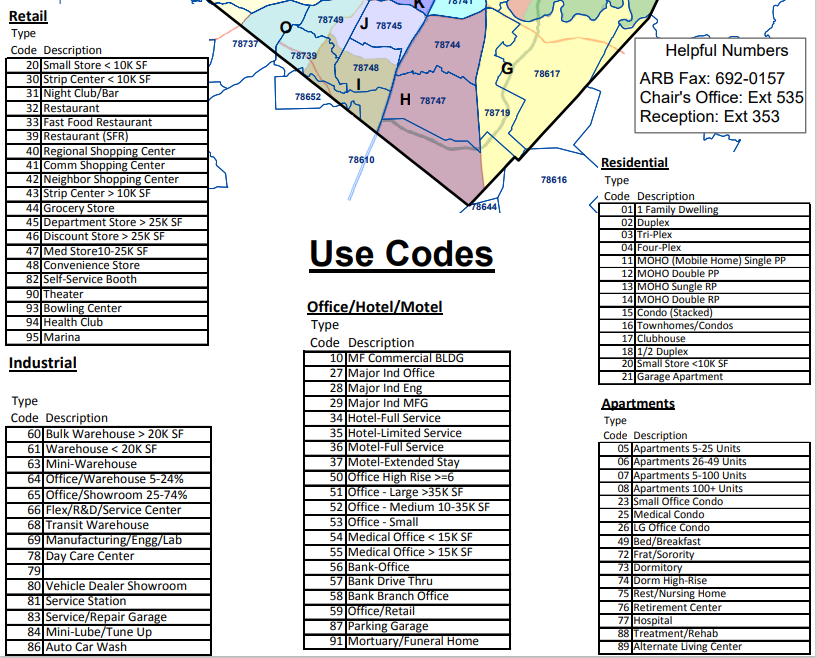

#### EYOC (effective year of construction or year built)

The same document by the Texas Comptroller of Public Account describes EYOC, which is the "year built and the effective year of construction" (TCAD 2014), and this information is in the TXBC_SUM_1990 file. This matches with one of our deliverables of effect date built on the microfiche. However, I believe that there's some error with the data that was given to us from the TCAD and that there is a possible outcome with the years 2971 and 0984. And in the data of EYOC, there are also both None and 0000 and they are probably presenting the same meaning that they do not have the data for some records.

#### Deed information (volume, page, and date)

Any deed information can only be found in the TXBC_SUM_1990 file. The deed volume and page number only have one outcome throughout, for both are all presented with "00000". And the deed date only has one record of "1900-00-00". The reason resulting in this information is possibly due to different systems of collection of appraisal in 1900 and exportation in 2004.

#### Land appraised value and improvement appraised value

Part of the important deliverable is the land appraised value and the improvement appraised value, and this information can only be found in the TXBC_SUM_1990_JURIS file. Some interesting information is the value of `LandMktVal` seems to match with `LandApprdVal`, and `ImprMktVal` matches with the `ImprApprdVal`. And the total appraised value (`TotApprdVal`) is the sum of the land appraised value and improvement appraised value, which can be found in the TXBC_SUM_1990_JURIS file.

#### Owner name

The owner name (`OwnerName`) is the basic information that can be found in both TCBC_SUM_1990 and TXBC_SUM_1990. The records are different between these two files, but since the rest of the deliverables are from the TXBC files, it is more efficient to look at the TXBC_SUM_1990 for the records, unless working with the TCBC dataset.

#### Mailing address

The mailing address has split into a maximum of 5 cells from the TXBC_SUM_1990 file. By viewing the `MailCnt` before reading the mailing address (`MailAddr1`, `MailAddr2`, `MailAddr3`, `MailAddr4`, and `MailAddr5`) it can tell the information of how many cells the mailing address is split into.

#### Location

Location can also be found in both TCBC_SUM_1990 and TXBC_SUM_1990 datasets. With consistent reasoning, it is more efficient to continue using the TXBC file. There is a column of data that records the entire location, and six other columns are the split record of this appraisal history. If looking at the overall location information for the research, it can use the column called `FmtLoc`, and if would like to organize and get information about the location individually, then it is more efficient to just read separately for `LocStreet`, `LocHouse`, `LocFrac`, `LocAlpha`, `LocUnit`, and`LocZip`.

#### Legal description

Legal descriptions are stored in both TXBC and TCBC files that have the suffix LEGAL (`TXBC_SUM_1990_LEGAL` and `TCBC_SUM_1990_LEGAL`). Since the unique keys that are used are the `Parcel` and `OwnrId`, therefore we are using the TXBC information instead of TCBC. The pattern of the legal description has not yet been discovered with `LegalSub1`, `LegalSub2`, `LegalCd1`, `LegalLn1`, `LegalCd2`, `LegalLn2`, `LegalCd3`, `LegalLn3`, `LegalCd4`, `LegalLn4`, `LegalCd5`, `LegalLn5`, `LegalCd6`, and `LegalLn6`.

# Challenges and discussions

At the start of this project, we faced some difficulties in understanding the content of the data given. I took lots of time just browsing on the internet to look for the description of abbreviations that includes in the data, just like TCBC and TXBC means Travis County Basic Code and Travis County Extra-territory Basic Code, this definition is the most reasonable from my searches, but it still has the possibility that is representing something else. Another challenge that we haven't discovered is the data for lot size, this is one the important information for the client's research. To find the solution, we probably need to look into the TCAD website to find if there's any other data matching, this may need to dive in by individual records.

Some further discussion can be:

-   What data would fit in with the lot size?

-   Is there information on the file that started with RPT that we needed? It seems like the actual record summaries.

-   The actual definition of TCBC is Travis County Basic Code? And TXBC is Travis County Extra-territory Basic Code?

-   The name of the files all included 'SUM', does that mean summary?

# Reference (MLA)

"Reappraisal Plans for Tax Years 2015 & 2016." Comptroller.texas.gov, TRAVIS CENTRAL APPRAISAL DISTRICT, 19 Aug. 2014, comptroller.texas.gov/taxes/property-tax/reappraisals/. Accessed 14 Apr. 2023.